# Анализ дефолта

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from collections import Counter

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, log_loss 
from sklearn.metrics import r2_score, f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve

Цветовая схема:


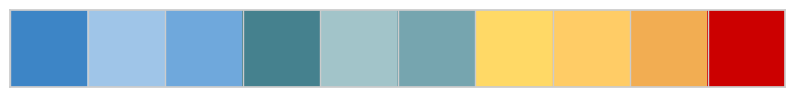

In [3]:
#whitegrid,darkgrid,white,ticks,white
sns.set_theme(style="whitegrid")#, font_scale=2
plt.rcParams["figure.figsize"] = (20,10)
my_colors = ['#3d85c6', '#9fc5e8', '#6fa8dc', '#45818e', '#a2c4c9', '#76a5af', '#ffd966', '#ffcc66', '#f2ad52', '#cc0000']
#pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

print("Цветовая схема:")
sns.palplot(sns.color_palette(my_colors))
plt.show()

In [4]:
#увеличиваю отображение таблиц в ячейках вывода, чтобы показывало все данные
pd.options.display.max_rows = 80
pd.options.display.max_columns = 75

In [4]:
DATA_DIR = Path("D:/Документы/Python/тестовые/АПР")

# План действий:
### - EDA (разведочный анализ данных) в том числе с небольшими преобразованиями для интерпритации)
### - Предобработка данных 
### - Обучение модели 
### - Предсказание

# EDA

In [5]:
data  = pd.read_csv(DATA_DIR/"all_reject_data.csv" ) # данные по отмененным или неодобренным кредитам 

In [6]:
data_prev  = pd.read_csv(DATA_DIR/"new_training_data_31_08_2022.csv" ) #ранее выданные кредиты, c целевой переменной

In [9]:
data

,Unnamed: 0,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,is_lost_100,micro_loans_active_100,is_active_12,open_sum_12,isnt_active_12,is_lost_12,overdue_loans_12,micro_loans_active_12,is_active_3,open_sum_3,isnt_active_3,is_lost_3,overdue_loans_3,micro_loans_active_3,is_active_1,open_sum_1,isnt_active_1,is_lost_1,micro_loans_active_1,ratio_all_microloans_3_to_12,ratio_overdue_loans_3_to_12,ratio_history_100,ratio_history_12,fraction_last_x_12,ratio_history_3,fraction_last_x_3,ratio_history_1,fraction_last_x_1,mean_delay_100_with_lag,mean_delay_12_with_lag,mean_delay_3_with_lag,mean_delay_1_with_lag,ratio_mean_delay_3_to_12,count_all_credits,ratio_pattern_len_to_pattern_1,ratio_pattern_len_to_pattern_2,ratio_pattern_len_to_pattern_3,ratio_pattern_len_to_pattern_4,ratio_pattern_len_to_pattern_bad_len,last_microloan_openeddt,is_type_credit_card_100,is_type_consumer_100,is_type_micro_100,is_active_type_credit_card_100,is_active_type_consumer_100,is_active_type_micro_100,is_type_credit_card_12,is_type_consumer_12,is_type_micro_12,is_active_type_credit_card_12,is_active_type_consumer_12,is_active_type_micro_12,is_type_credit_card_3,is_type_consumer_3,is_type_micro_3,is_active_type_credit_card_3,is_active_type_consumer_3,is_active_type_micro_3,is_type_credit_card_1,is_type_consumer_1,is_type_micro_1,is_active_type_credit_card_1,is_active_type_consumer_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum
0,4,35.0,903.0,44683.0,0.0,43335.0,3.0,0.0,0.0,3500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,120.000000,0.000000,0.000000,0.000000,NaN,3.0,0.0,0.0,0.022222,0.022222,0.955556,1348.0,0.0,2.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.056551
1,6,32.0,4.0,0.0,0.0,1.0,31.0,361.0,0.0,403828.0,27.0,333828.0,187.0,0.0,0.0,333828.0,16.0,285828.0,23.0,0.0,0.0,285828.0,14.0,241828.0,6.0,0.0,241828.0,0.237500,NaN,0.000000,0.000000,0.545918,0.000,0.099490,0.000,0.051020,0.240000,0.000000,0.000000,0.000000,NaN,450.0,0.0,0.0,0.000000,0.000000,0.000000,4.0,3.0,2.0,445.0,1.0,0.0,30.0,1.0,2.0,240.0,0.0,0.0,27.0,0.0,0.0,57.0,0.0,0.0,16.0,0.0,0.0,35.0,0.0,0.0,14.0,0.0,NaN
2,9,25.0,17.0,0.0,0.0,1.0,31.0,29.0,0.0,401027.0,31.0,401027.0,28.0,0.0,0.0,401027.0,30.0,386027.0,17.0,0.0,0.0,386027.0,1.0,4000.0,0.0,0.0,4000.0,0.753623,NaN,0.000000,0.000000,0.983333,0.000,0.783333,0.000,0.016667,3.628571,3.214286,3.214286,3.214286,1.000000,70.0,0.0,0.0,0.000000,0.000000,0.000000,17.0,0.0,1.0,69.0,0.0,0.0,31.0,0.0,0.0,69.0,0.0,0.0,31.0,0.0,0.0,52.0,0.0,0.0,30.0,0.0,0.0,1.0,0.0,0.0,1.0,59.0,0.557095
3,10,42.0,2.0,0.0,0.0,1.0,38.0,206.0,0.0,844402.0,36.0,824602.0,131.0,0.0,0.0,824602.0,26.0,471052.0,18.0,0.0,0.0,471052.0,11.0,215779.0,1.0,0.0,215779.0,0.281081,NaN,0.000000,0.000000,0.684426,0.000,0.180328,0.000,0.049180,0.825279,0.665428,0.319703,0.133829,0.480447,269.0,0.0,0.0,0.000000,0.000000,0.000000,2.0,0.0,0.0,263.0,0.0,0.0,38.0,0.0,0.0,185.0,0.0,0.0,36.0,0.0,0.0,52.0,0.0,0.0,26.0,0.0,0.0,12.0,0.0,0.0,11.0,29.0,0.092473
4,12,38.0,204.0,73.0,0.0,1.0,39.0,98.0,0.0,600680.0,33.0,500980.0,67.0,0.0,0.0,500980.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,0.000000,0.000000,0.729927,NaN,0.000000,NaN,0.000000,5.459627,3.453416,0.000000,0.000000,0.000000,161.0,1.0,0.0,0.000000,0.000000,0.000000,204.0,0.0,6.0,152.0,0.0,0.0,39.0,0.0,0.0,113.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,0.084674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106506,91643,31.0,4.0,0.0,0.0,2.0,7.0,5.0,2.0,44425.0,7.0,69425.0,2.0,1.0,0.0,44425.0,6.0,44425.0,2.0,1.0,0.0,44425.0,6.0

In [11]:
data_prev

,Unnamed: 0,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,is_lost_100,micro_loans_active_100,is_active_12,open_sum_12,isnt_active_12,is_lost_12,overdue_loans_12,micro_loans_active_12,is_active_3,open_sum_3,isnt_active_3,is_lost_3,overdue_loans_3,micro_loans_active_3,is_active_1,open_sum_1,isnt_active_1,is_lost_1,micro_loans_active_1,ratio_all_microloans_3_to_12,ratio_overdue_loans_3_to_12,ratio_history_100,ratio_history_12,fraction_last_x_12,ratio_history_3,fraction_last_x_3,ratio_history_1,fraction_last_x_1,mean_delay_100_with_lag,mean_delay_12_with_lag,mean_delay_3_with_lag,mean_delay_1_with_lag,ratio_mean_delay_3_to_12,count_all_credits,ratio_pattern_len_to_pattern_1,ratio_pattern_len_to_pattern_2,ratio_pattern_len_to_pattern_3,ratio_pattern_len_to_pattern_4,ratio_pattern_len_to_pattern_bad_len,last_microloan_openeddt,is_type_credit_card_100,is_type_consumer_100,is_type_micro_100,is_active_type_credit_card_100,is_active_type_consumer_100,is_active_type_micro_100,is_type_credit_card_12,is_type_consumer_12,is_type_micro_12,is_active_type_credit_card_12,is_active_type_consumer_12,is_active_type_micro_12,is_type_credit_card_3,is_type_consumer_3,is_type_micro_3,is_active_type_credit_card_3,is_active_type_consumer_3,is_active_type_micro_3,is_type_credit_card_1,is_type_consumer_1,is_type_micro_1,is_active_type_credit_card_1,is_active_type_consumer_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum,target
0,0,43.0,81.0,235.0,0.0,4.0,34.0,70.0,0.0,421478.0,4.0,36458.0,3.0,0.0,0.0,18000.0,1.0,8458.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,0.000000,0.000000,0.067308,0.000000,0.009615,NaN,0.000000,31.566929,8.015748,0.228346,0.228346,0.028487,127.0,0.0,0.0,0.0,0.0,0.875,289.0,1.0,2.0,115.0,1.0,1.0,32.0,1.0,1.0,5.0,1.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0,0.942917,0.0
1,1,35.0,3.0,0.0,0.0,1.0,41.0,36.0,0.0,627578.0,39.0,1902599.0,34.0,0.0,0.0,627578.0,33.0,583578.0,22.0,0.0,0.0,583578.0,14.0,348778.0,5.0,0.0,348778.0,0.794872,NaN,0.000000,0.000000,0.948052,0.000000,0.714286,0.000000,0.246753,0.322222,0.322222,0.000000,0.000000,0.000000,90.0,0.0,0.0,0.0,0.0,0.000,3.0,4.0,7.0,78.0,4.0,1.0,36.0,2.0,1.0,78.0,2.0,1.0,36.0,0.0,0.0,62.0,0.0,0.0,33.0,0.0,0.0,20.0,0.0,0.0,14.0,7.0,NaN,0.0
2,2,27.0,19.0,65.0,0.0,7.0,25.0,34.0,0.0,214655.0,9.0,96195.0,6.0,0.0,0.0,96195.0,2.0,29156.0,0.0,0.0,0.0,29156.0,1.0,25436.0,0.0,0.0,25436.0,0.133333,NaN,0.000000,0.000000,0.254237,0.000000,0.033898,0.000000,0.016949,36.107692,18.953846,0.000000,0.000000,0.000000,65.0,0.0,0.0,0.0,0.0,0.000,19.0,3.0,2.0,60.0,3.0,1.0,21.0,0.0,0.0,15.0,0.0,0.0,9.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,120.0,0.098896,1.0
3,3,32.0,14.0,76.0,0.0,11.5,13.0,35.0,0.0,88856.0,11.0,88856.0,10.0,0.0,0.0,88856.0,9.0,66856.0,0.0,0.0,0.0,66856.0,5.0,28666.0,0.0,0.0,28666.0,0.360000,NaN,0.000000,0.000000,0.437500,0.000000,0.187500,0.000000,0.104167,2.033333,1.550000,1.083333,0.000000,0.698925,60.0,0.0,0.0,0.0,0.0,0.000,14.0,2.0,0.0,58.0,2.0,0.0,11.0,0.0,0.0,25.0,0.0,0.0,11.0,0.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,5.0,0.0,0.0,5.0,59.0,0.298009,1.0
4,5,23.0,5.0,0.0,0.0,1.0,26.0,52.0,0.0,345820.0,26.0,371008.0,36.0,0.0,0.0,345820.0,19.0,251720.0,5.0,0.0,0.0,251720.0,12.0,131720.0,2.0,0.0,131720.0,0.366197,NaN,0.000000,0.000000,0.794872,0.000000,0.307692,0.000000,0.179487,2.647727,0.647727,0.318182,0.000000,0.491228,88.0,0.0,0.0,0.0,0.0,0.000,5.0,0.0,2.0,86.0,0.0,1.0,25.0,0.0,1.0,71.0,0.0,1.0,25.0,0.0,0.0,26.0,0.0,0.0,19.0,0.0,0.0,16.0,0.0,0.0,12.0,29.0,0.031670,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42524,35680,51.0,4.0,0.0,0.0,5.0,18.0,52.0,3.0,287540.0,16.0,294403.0,20.0,1.0,0.0,287540.0,12.0,1

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106511 entries, 0 to 106510
Data columns (total 74 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            106511 non-null  int64  
 1   age                                   106511 non-null  float64
 2   lastcredit                            106511 non-null  float64
 3   time_to_lastcredit_closeddt           106511 non-null  float64
 4   close_loan_median                     106373 non-null  float64
 5   open_loan_median                      106373 non-null  float64
 6   is_active_100                         106511 non-null  float64
 7   isnt_active_100                       106511 non-null  float64
 8   is_lost_100                           106511 non-null  float64
 9   micro_loans_active_100                106511 non-null  float64
 10  is_active_12                          106511 non-null  float64
 11  

In [13]:
data_prev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42529 entries, 0 to 42528
Data columns (total 75 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Unnamed: 0                            42529 non-null  int64  
 1   age                                   42529 non-null  float64
 2   lastcredit                            42529 non-null  float64
 3   time_to_lastcredit_closeddt           42529 non-null  float64
 4   close_loan_median                     42520 non-null  float64
 5   open_loan_median                      42520 non-null  float64
 6   is_active_100                         42529 non-null  float64
 7   isnt_active_100                       42529 non-null  float64
 8   is_lost_100                           42529 non-null  float64
 9   micro_loans_active_100                42529 non-null  float64
 10  is_active_12                          42529 non-null  float64
 11  open_sum_12    

In [8]:
data.drop_duplicates(inplace=True)
data_prev.drop_duplicates(inplace=True)

In [145]:
data.describe().applymap(lambda x: f"{x:0.3f}")

,Unnamed: 0,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,is_lost_100,micro_loans_active_100,is_active_12,open_sum_12,isnt_active_12,is_lost_12,overdue_loans_12,micro_loans_active_12,is_active_3,open_sum_3,isnt_active_3,is_lost_3,overdue_loans_3,micro_loans_active_3,is_active_1,open_sum_1,isnt_active_1,is_lost_1,micro_loans_active_1,ratio_all_microloans_3_to_12,ratio_overdue_loans_3_to_12,ratio_history_100,ratio_history_12,fraction_last_x_12,ratio_history_3,fraction_last_x_3,ratio_history_1,fraction_last_x_1,mean_delay_100_with_lag,mean_delay_12_with_lag,mean_delay_3_with_lag,mean_delay_1_with_lag,ratio_mean_delay_3_to_12,count_all_credits,ratio_pattern_len_to_pattern_1,ratio_pattern_len_to_pattern_2,ratio_pattern_len_to_pattern_3,ratio_pattern_len_to_pattern_4,ratio_pattern_len_to_pattern_bad_len,last_microloan_openeddt,is_type_credit_card_100,is_type_consumer_100,is_type_micro_100,is_active_type_credit_card_100,is_active_type_consumer_100,is_active_type_micro_100,is_type_credit_card_12,is_type_consumer_12,is_type_micro_12,is_active_type_credit_card_12,is_active_type_consumer_12,is_active_type_micro_12,is_type_credit_card_3,is_type_consumer_3,is_type_micro_3,is_active_type_credit_card_3,is_active_type_consumer_3,is_active_type_micro_3,is_type_credit_card_1,is_type_consumer_1,is_type_micro_1,is_active_type_credit_card_1,is_active_type_consumer_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum
count,106511.000,106511.000,106511.000,106511.000,106373.000,106373.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,105922.000,91648.000,106484.000,106020.000,106484.000,104127.000,106484.000,102637.000,106484.000,106511.000,106511.000,106511.000,106511.000,103608.000,106511.000,106373.000,106373.000,106373.000,106373.000,106373.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,106511.000,105131.000
mean,41128.348,32.786,36.525,379.741,4.191,2343.082,10.542,32.872,2.540,111835.747,8.545,177474.634,19.331,1.958,0.000,100686.278,6.376,88176.988,6.037,0.846,0.000,74227.538,4.202,46611.987,1.169,0.133,43800.920,0.598,0.000,0.088,0.104,0.689,0.088,0.411,0.027,0.229,20.989,8.651,2.991,0.820,0.312,51.515,0.175,0.065,0.064,0.063,-0.051,94.438,1.934,3.475,44.267,1.245,0.759,8.511,0.512,0.588,29.805,0.475,0.305,7.758,0.115,0.154,13.506,0.112,0.087,6.176,0.030,0.051,5.877,0.030,0.034,4.138,49.042,nan
std,27290.103,8.869,107.932,4022.285,58.106,8826.455,10.287,56.093,4.295,184894.741,9.118,448427.184,32.349,3.873,0.000,159704.145,7.519,220027.803,10.237,2.029,0.000,116512.259,5.390,96355.684,2.604,0.524,70803.245,0.374,0.000,0.135,0.184,0.293,0.194,0.322,0.117,0.260,22.937,15.215,7.750,2.911,0.396,71.449,0.364,0.182,0.181,0.181,0.400,1610.501,2.502,5.516,68.192,1.652,1.322,9.047,1.027,1.525,42.277,0.958,0.771,8.620,0.464,0.642,18.264,0.455,0.361,7.383,0.237,0.323,8.367,0.232,0.214,5.342,48.006,nan
min,0.000,18.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,-2.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-inf
25%,16471.000,26.000,4.000,0.000,0.000,1.500,3.000,5.000,0.000,17000.000,2.000,17000.000,2.000,0.000,0.000,13000.000,1.000,6500.000,0.000,0.000,0.000,6000.000,0.000,0.000,0.000,0.000,0.000,0.250,0.000,0.000,0

### выбросы присутствуют почти во всех колонках,  в overall_worst_overdue_state_12 длинный хвост, но в рамках

In [146]:
data_prev.describe().applymap(lambda x: f"{x:0.3f}")

,Unnamed: 0,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,is_lost_100,micro_loans_active_100,is_active_12,open_sum_12,isnt_active_12,is_lost_12,overdue_loans_12,micro_loans_active_12,is_active_3,open_sum_3,isnt_active_3,is_lost_3,overdue_loans_3,micro_loans_active_3,is_active_1,open_sum_1,isnt_active_1,is_lost_1,micro_loans_active_1,ratio_all_microloans_3_to_12,ratio_overdue_loans_3_to_12,ratio_history_100,ratio_history_12,fraction_last_x_12,ratio_history_3,fraction_last_x_3,ratio_history_1,fraction_last_x_1,mean_delay_100_with_lag,mean_delay_12_with_lag,mean_delay_3_with_lag,mean_delay_1_with_lag,ratio_mean_delay_3_to_12,count_all_credits,ratio_pattern_len_to_pattern_1,ratio_pattern_len_to_pattern_2,ratio_pattern_len_to_pattern_3,ratio_pattern_len_to_pattern_4,ratio_pattern_len_to_pattern_bad_len,last_microloan_openeddt,is_type_credit_card_100,is_type_consumer_100,is_type_micro_100,is_active_type_credit_card_100,is_active_type_consumer_100,is_active_type_micro_100,is_type_credit_card_12,is_type_consumer_12,is_type_micro_12,is_active_type_credit_card_12,is_active_type_consumer_12,is_active_type_micro_12,is_type_credit_card_3,is_type_consumer_3,is_type_micro_3,is_active_type_credit_card_3,is_active_type_consumer_3,is_active_type_micro_3,is_type_credit_card_1,is_type_consumer_1,is_type_micro_1,is_active_type_credit_card_1,is_active_type_consumer_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum,target
count,42529.000,42529.000,42529.000,42529.000,42520.000,42520.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42497.000,35685.000,42529.000,42506.000,42529.000,42311.000,42529.000,42136.000,42529.000,42529.000,42529.000,42529.000,42529.000,39968.000,42529.000,42520.000,42520.000,42520.000,42520.000,42520.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,42529.000,39729.000,42529.000
mean,16848.108,34.810,10.636,127.219,0.342,208.410,20.514,59.126,0.601,273248.642,17.979,434158.225,41.251,0.334,0.000,263018.555,15.395,251713.521,17.808,0.197,0.000,224423.387,10.908,152407.522,3.656,0.050,144473.919,0.664,0.000,0.010,0.006,0.765,0.005,0.502,0.003,0.251,6.131,1.260,0.360,0.121,0.235,96.075,0.262,0.001,0.001,0.000,0.020,80.728,3.126,5.436,85.083,2.049,1.193,17.227,0.793,1.169,66.454,0.718,0.558,16.690,0.139,0.412,38.021,0.133,0.187,15.073,0.032,0.170,16.745,0.031,0.099,10.776,105.648,nan,0.277
std,10120.477,8.824,75.481,2343.824,13.085,2694.463,14.096,93.771,1.678,257212.958,12.963,754649.746,53.451,1.127,0.000,250250.621,11.371,341810.301,21.241,0.734,0.000,204276.117,8.590,215238.488,5.695,0.336,137133.150,0.271,0.000,0.030,0.027,0.237,0.023,0.257,0.023,0.184,10.100,3.376,1.240,0.464,0.371,120.402,0.434,0.014,0.011,0.010,0.109,1762.086,3.360,7.670,116.721,2.212,1.704,12.268,1.327,2.459,70.280,1.200,1.074,12.304,0.523,1.181,35.370,0.501,0.544,11.206,0.260,0.601,15.945,0.248,0.381,8.510,36.631,nan,0.448
min,0.000,18.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-inf,0.000
25%,8134.000,28.000,2.000,0.000,0.000,1.000,11.000,17.000,0.000,101820.000,9.000,121825.000,10.000,0.000,0.000,93022.000,7.000,86981.000,5.000,0.000,0.000,80506.000,5.000,51680.000,0.000,0.000,50000.000,0.447,0.000,0.000,0.000,0

### выбросы присутствуют почти во всех колонках

### интересно, что присутствует inf в ratio_sum_outstanding_to_open_sum в обоих датасетах, так как обучение будет на data_prev,  если буду изменять, то изменение этих значений должно быть одинаковым 

In [7]:
def find_missing_values(df, percent):
    '''выводит названия колонок 
    в которых процент пропущенных больше границы '''
    print(f'Колонки с долей пропущенных значений больше {percent}%')
    lost_col = [] #сохраняю колонки где пропуски, чтобы была возможность быстро заполнить или удалить  
    for col in df.columns:
        pct_missing = np.mean(df[col].isnull())*100
        if pct_missing > percent:
            lost_col.append(col)
            print('{} - {}%'.format(col, round(pct_missing, 4)))
    print(f'Общее количество колонок с пропусками - {len(lost_col)}')        
    return lost_col

In [8]:
lost_col_data = find_missing_values(data, 0)

Колонки с долей пропущенных значений больше 0%
close_loan_median - 0.1296%
open_loan_median - 0.1296%
ratio_all_microloans_3_to_12 - 0.553%
ratio_overdue_loans_3_to_12 - 13.9544%
ratio_history_100 - 0.0253%
ratio_history_12 - 0.461%
fraction_last_x_12 - 0.0253%
ratio_history_3 - 2.2383%
fraction_last_x_3 - 0.0253%
ratio_history_1 - 3.6372%
fraction_last_x_1 - 0.0253%
ratio_mean_delay_3_to_12 - 2.7255%
ratio_pattern_len_to_pattern_1 - 0.1296%
ratio_pattern_len_to_pattern_2 - 0.1296%
ratio_pattern_len_to_pattern_3 - 0.1296%
ratio_pattern_len_to_pattern_4 - 0.1296%
ratio_pattern_len_to_pattern_bad_len - 0.1296%
ratio_sum_outstanding_to_open_sum - 1.2956%
Общее количество колонок с пропусками - 18


In [9]:
lost_col_data_prev = find_missing_values(data_prev, 0)

Колонки с долей пропущенных значений больше 0%
close_loan_median - 0.0212%
open_loan_median - 0.0212%
ratio_all_microloans_3_to_12 - 0.0752%
ratio_overdue_loans_3_to_12 - 16.0925%
ratio_history_12 - 0.0541%
ratio_history_3 - 0.5126%
ratio_history_1 - 0.9241%
ratio_mean_delay_3_to_12 - 6.0218%
ratio_pattern_len_to_pattern_1 - 0.0212%
ratio_pattern_len_to_pattern_2 - 0.0212%
ratio_pattern_len_to_pattern_3 - 0.0212%
ratio_pattern_len_to_pattern_4 - 0.0212%
ratio_pattern_len_to_pattern_bad_len - 0.0212%
ratio_sum_outstanding_to_open_sum - 6.5837%
Общее количество колонок с пропусками - 14


### в целом немного колонок с пропусками, и больше 16% не наблюдается, в основном до 1%

Text(0.5, 1.0, 'Количество возвращенных/невозвращенных')

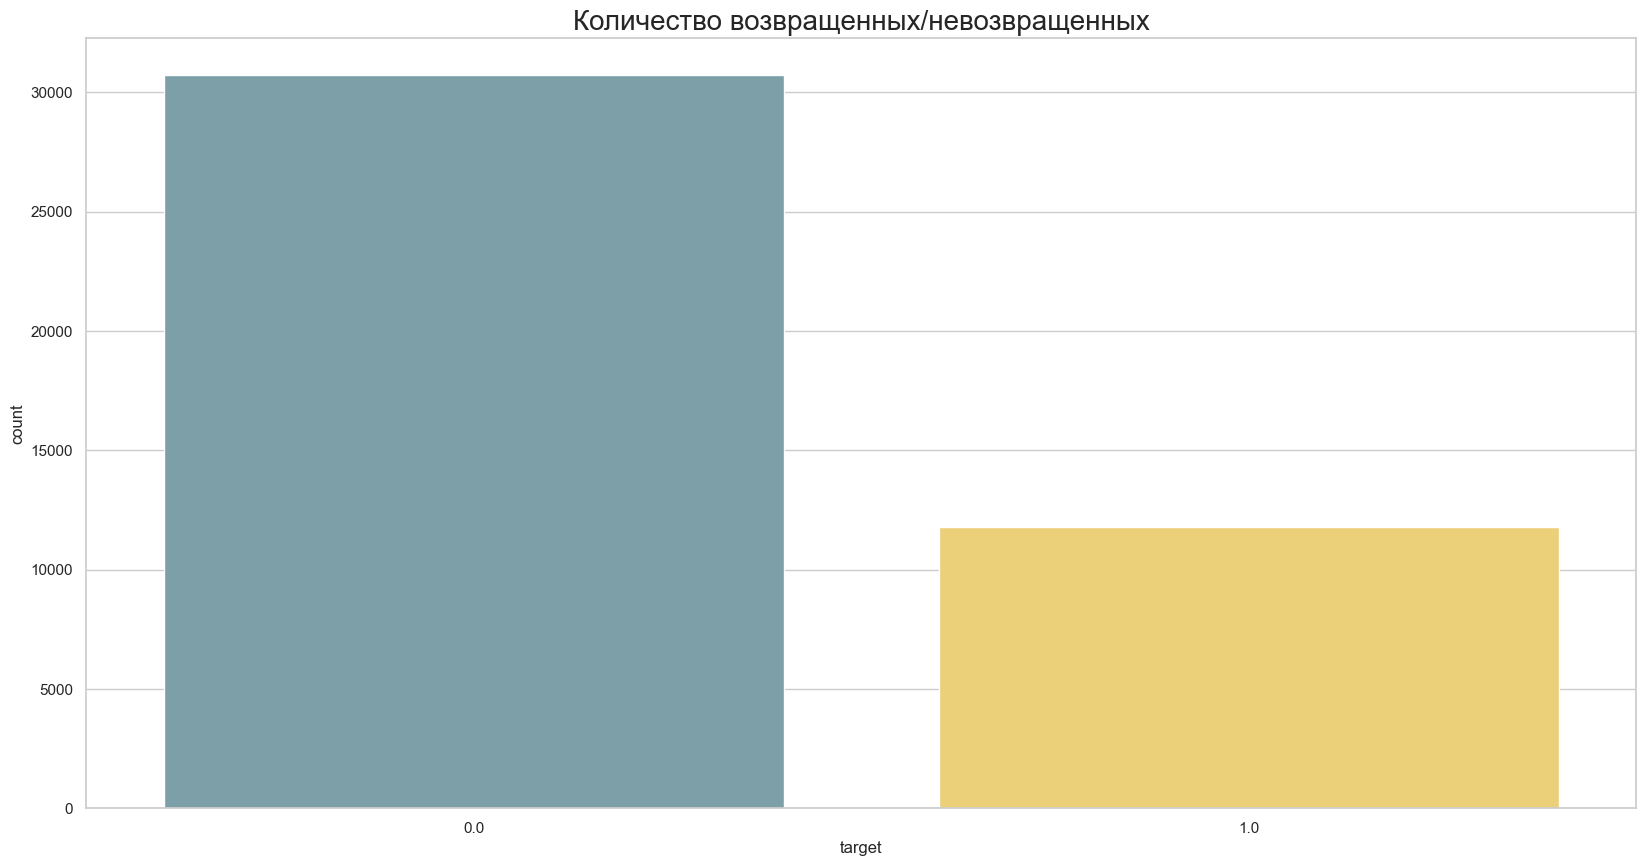

In [100]:
sns.countplot(data=data_prev, x='target', palette=my_colors[5:7])
plt.title('Количество возвращенных/невозвращенных', size=20)

### Дисбаланс целевой переменной

In [20]:
df_for_grafic = data.copy()
df_prev_for_grafic = data_prev.copy()

In [13]:
data['age'] = data['age'].astype('int16')
data_prev['age'] = data_prev['age'].astype('int16')

In [14]:
age_bins = [18,25,30,35,40,45,50,55,60,65,70,75,80,85,90]

df_prev_for_grafic['age_bins'] = pd.cut(df_prev_for_grafic['age'],bins=age_bins)
df_for_grafic['age_bins'] = pd.cut(df_for_grafic['age'],bins=age_bins)

Text(0.5, 1.0, 'Количество людей по возрастам среди выданных')

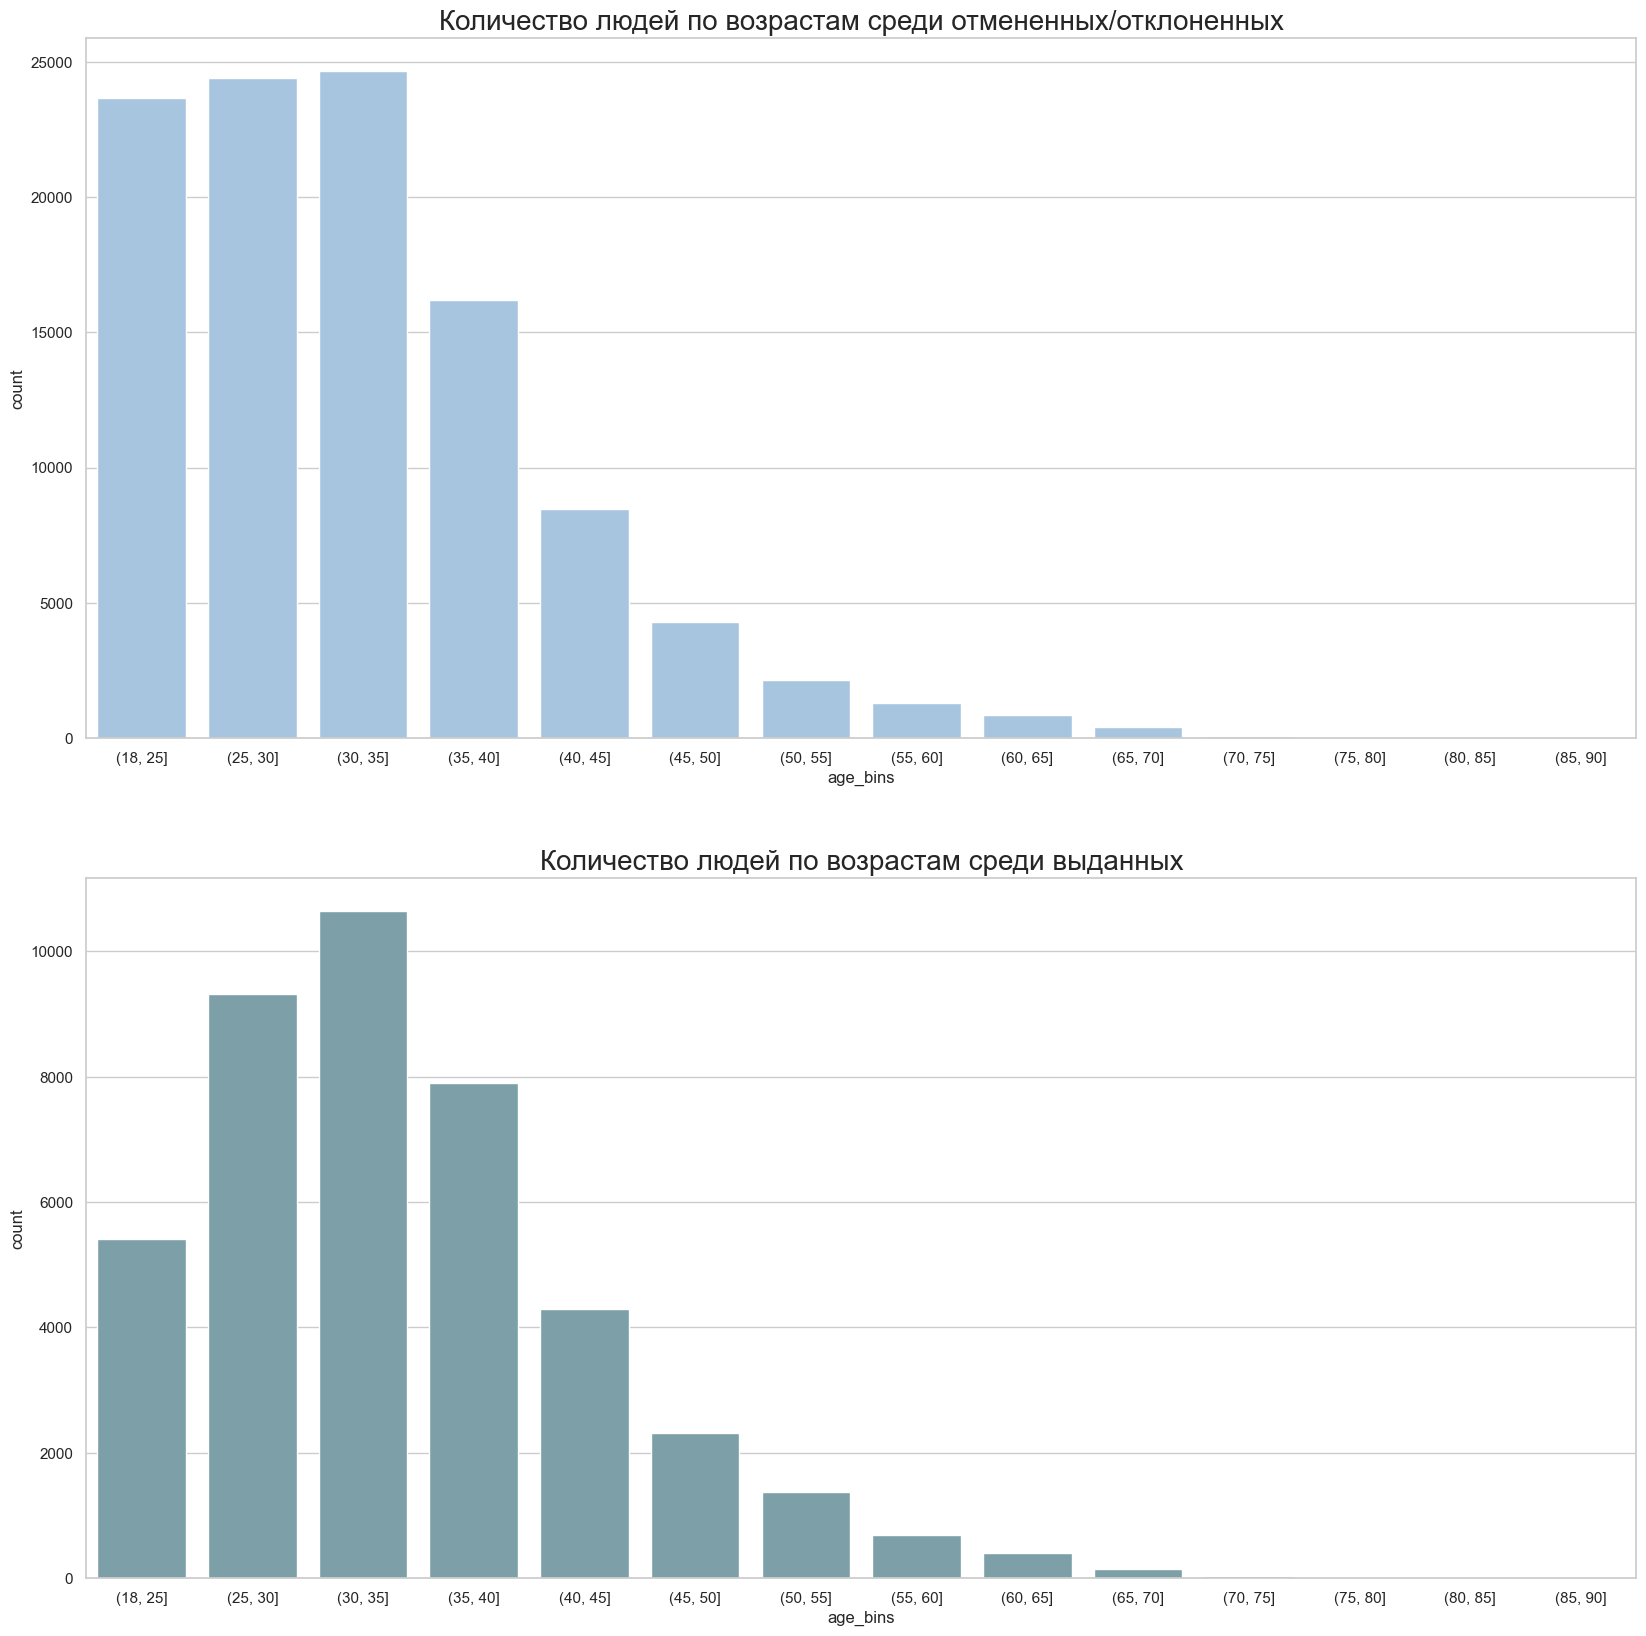

In [15]:
plt.figure(figsize=(20,20))

plt.subplot(2,1,1)
sns.countplot(data=df_for_grafic, x='age_bins', palette=my_colors[1:2])
plt.title('Количество людей по возрастам среди отмененных/отклоненных', size=20)

plt.subplot(2,1,2)
sns.countplot(data=df_prev_for_grafic, x='age_bins', palette=my_colors[5:6])
plt.title('Количество людей по возрастам среди выданных', size=20)

## в основном берут кредиты люди в 25-40 лет

Text(0.5, 1.0, 'Количество возвращенных/невозвращенных по возрасту клиента')

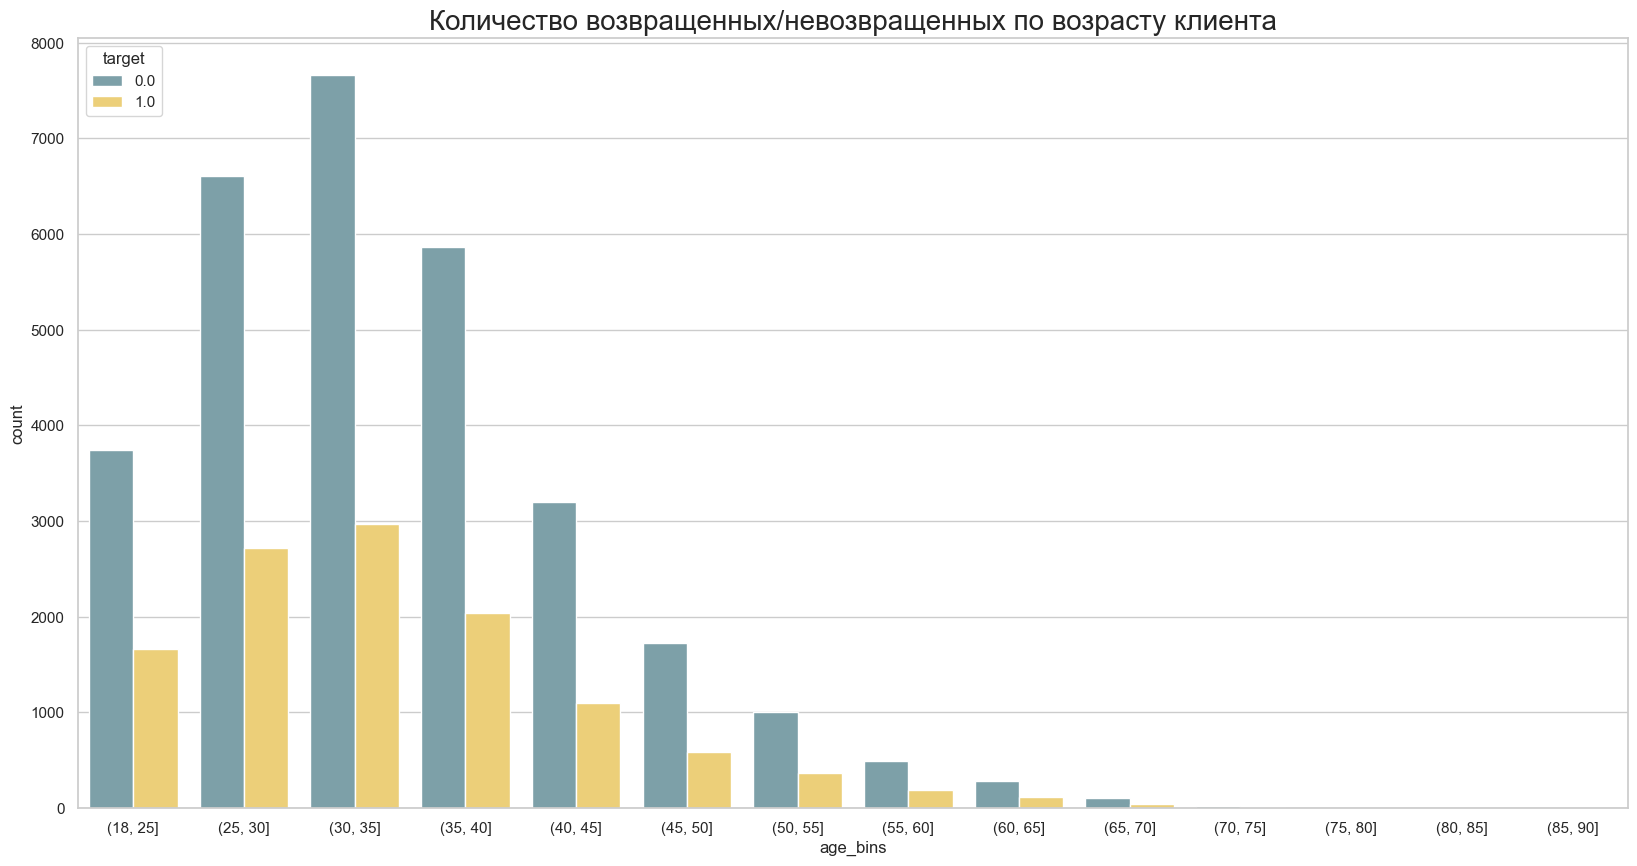

In [16]:
sns.countplot(data=df_prev_for_grafic, x='age_bins', hue = 'target', palette=my_colors[5:7])
plt.title('Количество возвращенных/невозвращенных по возрасту клиента', size=20)

## так как возрастные группы от 25 до 40 преобладают, в них также больше всего не возвращающих, но вероятность дефолта у группы 25-30 больше к ним приближается 18-25

In [17]:
data['isnt_active_100'] = data['isnt_active_100'].astype('int16')
data_prev['isnt_active_100'] = data_prev['isnt_active_100'].astype('int16')

Text(0.5, 1.0, 'Ограниченное распределение доли не возвращенных кредитов относительно всех кредитов, взятых за все время\nсреди выданных.')

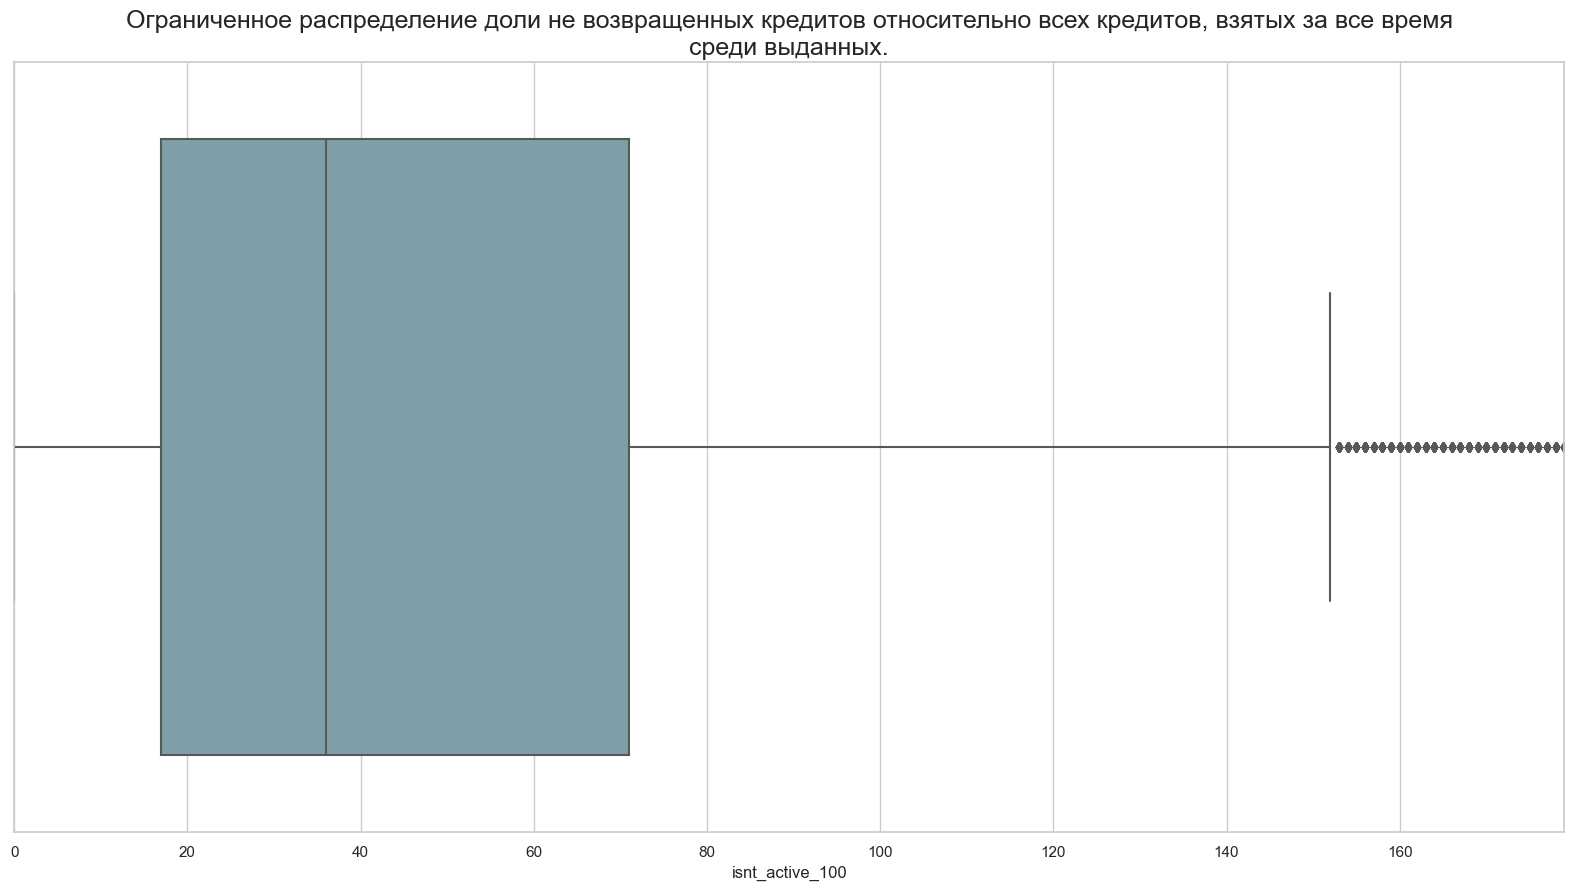

In [18]:
plt.figure(figsize=(20,10))

ax = sns.boxplot(data=data_prev, x='isnt_active_100', color=my_colors[5])
ax.set_xlim(0, data_prev['isnt_active_100'].quantile(0.95))
plt.title('Ограниченное распределение доли не возвращенных кредитов относительно всех кредитов, взятых за все время' "\n"
          'среди выданных.', fontsize=18)

Text(0.5, 1.0, 'Ограниченное распределение доли не возвращенных кредитов относительно всех кредитов, взятых за все время\nсреди отмененных/отклоненных')

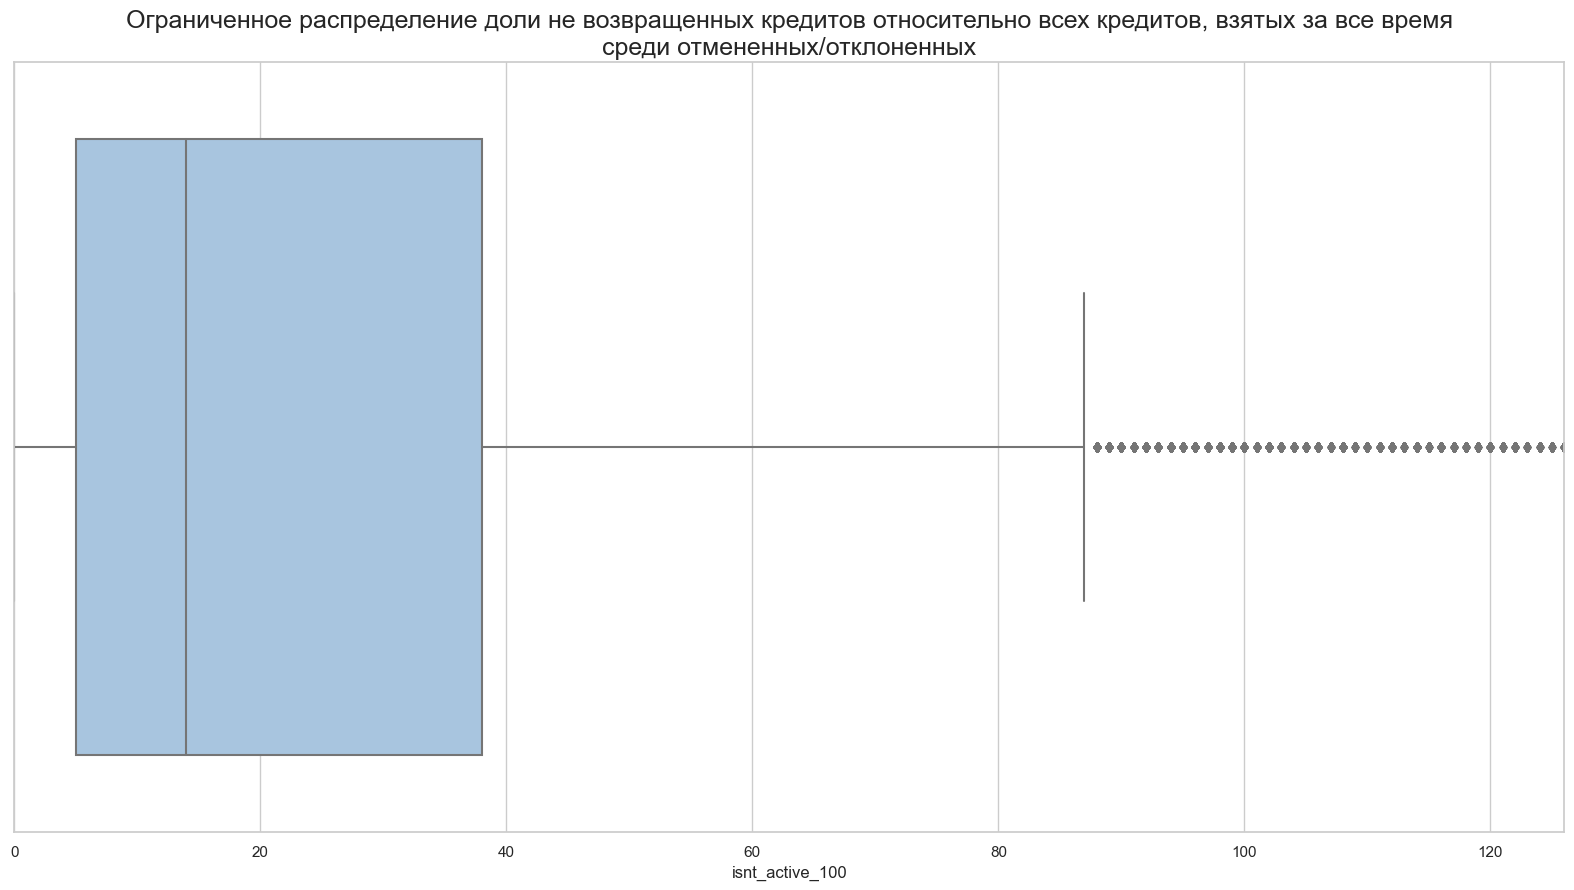

In [19]:
plt.figure(figsize=(20,10))

ax = sns.boxplot(data=data, x='isnt_active_100', color=my_colors[1])
ax.set_xlim(0, data['isnt_active_100'].quantile(0.95))
plt.title('Ограниченное распределение доли не возвращенных кредитов относительно всех кредитов, взятых за все время' "\n"
          'среди отмененных/отклоненных', fontsize=18)

Text(0.5, 1.0, 'Активная сумма микрокредитов, открытых за всё время среди выданных')

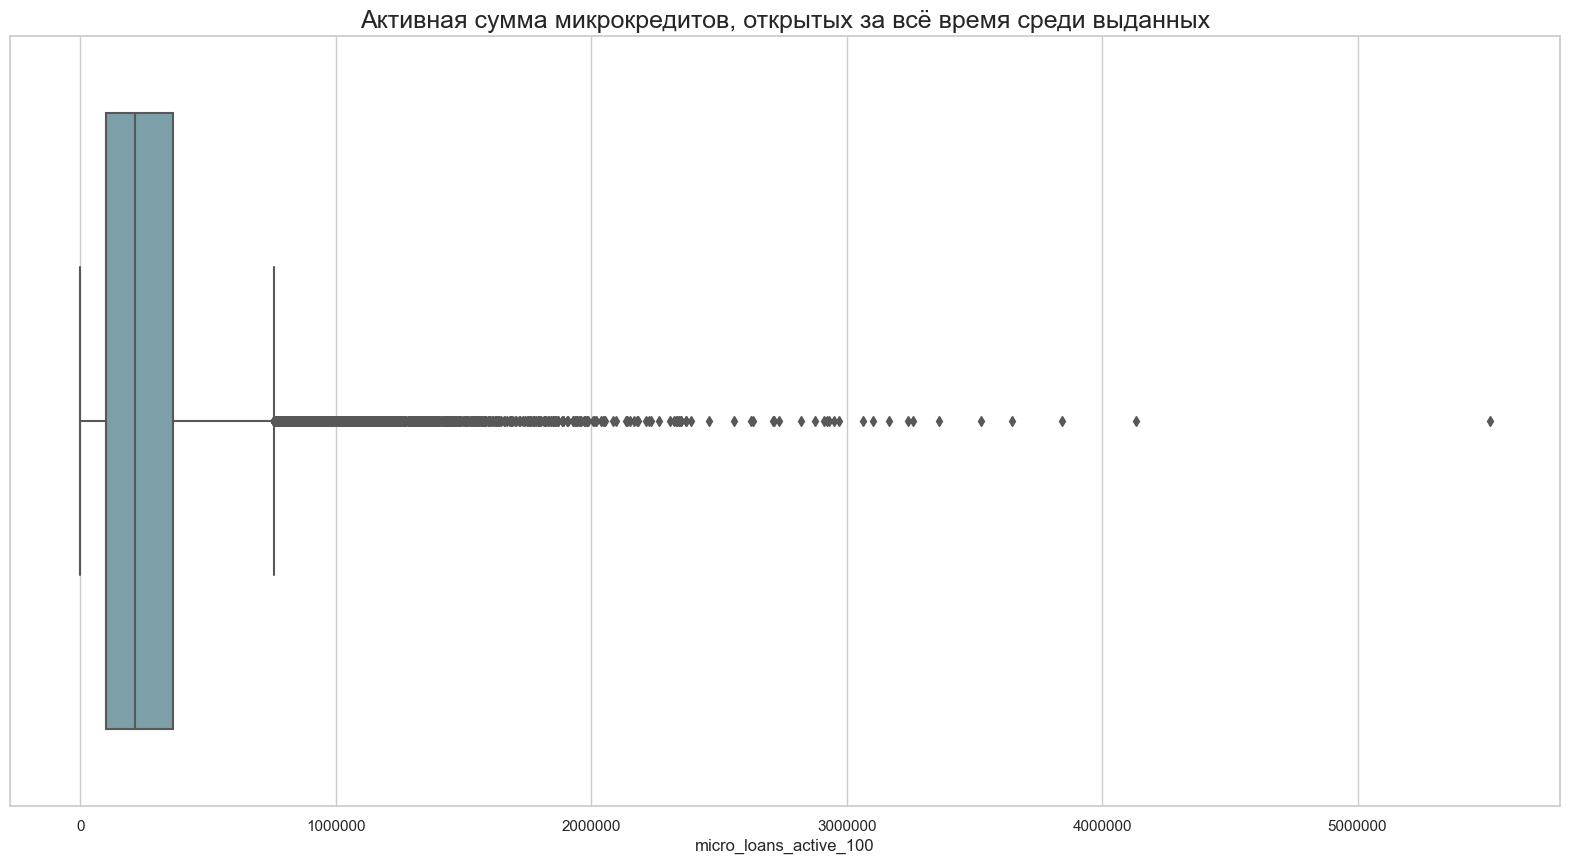

In [20]:
plt.figure(figsize=(20,10))

ax = sns.boxplot(data=data_prev, x='micro_loans_active_100', color=my_colors[5])
#ax.set_xlim(0, data_prev['micro_loans_active_100'].quantile(0.95))
plt.ticklabel_format(style='plain', axis='x')
plt.title('Активная сумма микрокредитов, открытых за всё время среди выданных', fontsize=18)

Text(0.5, 1.0, 'Активная сумма микрокредитов, открытых за всё время среди выданных')

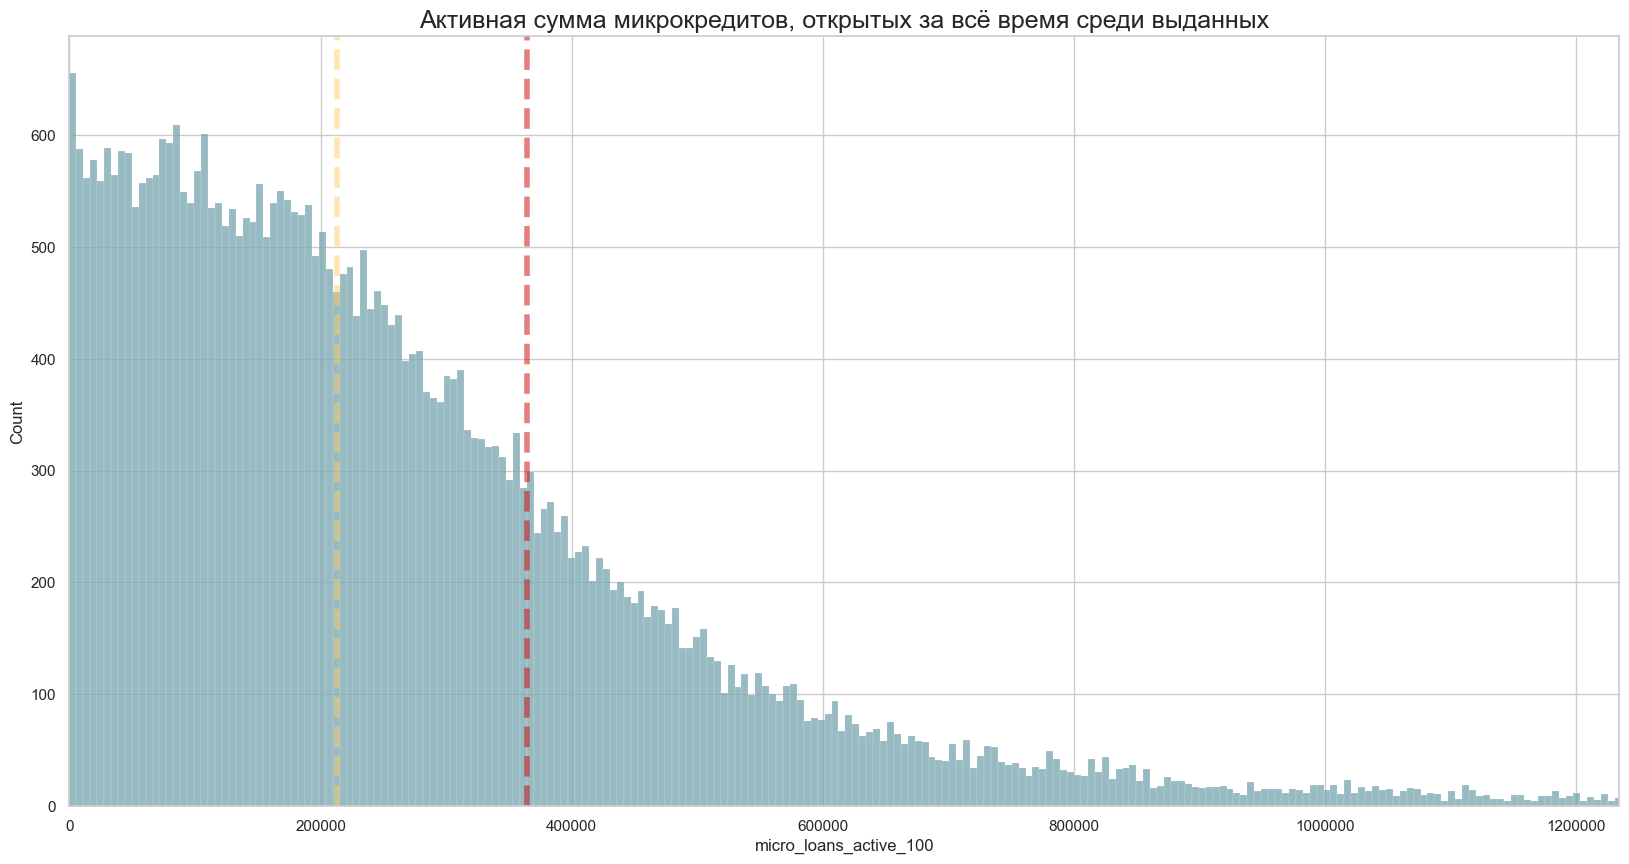

In [21]:
ax = sns.histplot(data_prev['micro_loans_active_100'], bins = 1000, color=my_colors[5])
ax.set_xlim(0, data_prev['micro_loans_active_100'].quantile(0.99))
plt.ticklabel_format(style='plain', axis='x')

ax.axvline(x=data_prev['micro_loans_active_100'].quantile(0.75),alpha=0.5,color=my_colors[9],linewidth=4,linestyle='--')
ax.axvline(x=data_prev['micro_loans_active_100'].quantile(0.50),alpha=0.5,color=my_colors[7],linewidth=4,linestyle='--')
plt.title('Активная сумма микрокредитов, открытых за всё время среди выданных', fontsize=18)

## 50% берут около 200 тысяч, 75% до 400 тысяч 

Text(0.5, 1.0, 'Активная сумма микрокредитов, открытых за всё время среди отмененных/отклоненных')

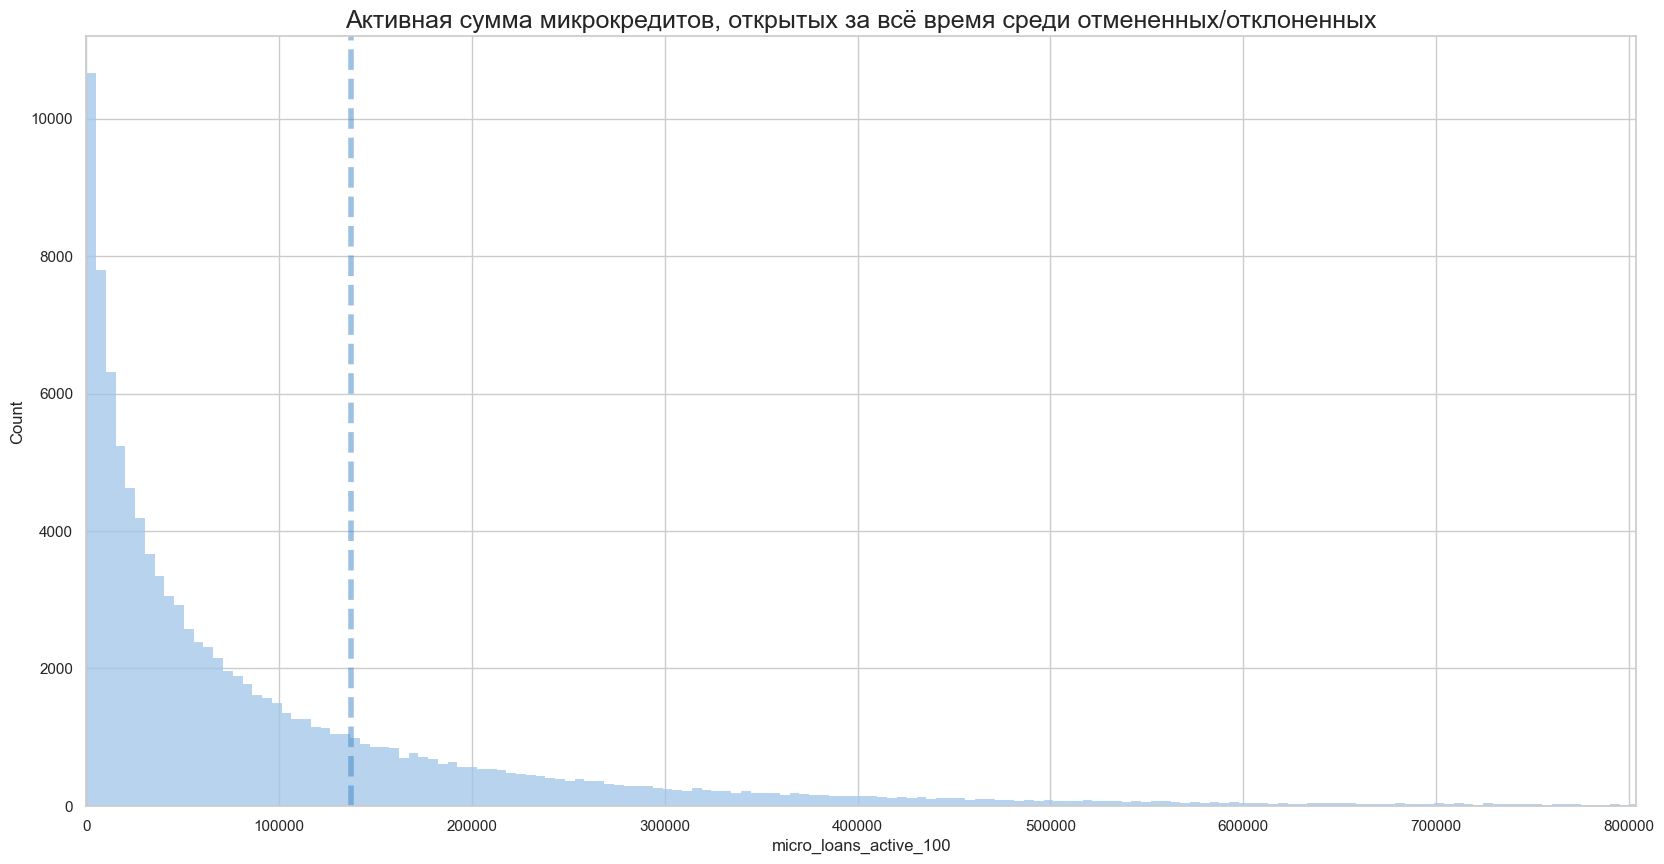

In [22]:
ax = sns.histplot(data['micro_loans_active_100'], color=my_colors[1])
ax.set_xlim(0, data['micro_loans_active_100'].quantile(0.99))
plt.ticklabel_format(style='plain', axis='x')

ax.axvline(x=data['micro_loans_active_100'].quantile(0.75),alpha=0.5,color=my_colors[0],linewidth=4,linestyle='--')
plt.title('Активная сумма микрокредитов, открытых за всё время среди отмененных/отклоненных', fontsize=18)

In [21]:
is_type_credit_card_100_bins = [0,2,4,6,8,10,12,14,15,20,25,30,40,50,100,150]

df_prev_for_grafic['is_type_credit_card_100_bins'] = pd.cut(df_prev_for_grafic['is_type_credit_card_100'], \
                                                            bins=is_type_credit_card_100_bins)
df_for_grafic['is_type_credit_card_100_bins'] = pd.cut(df_for_grafic['is_type_credit_card_100'], \
                                                       bins=is_type_credit_card_100_bins)

In [22]:
is_type_consumer_100_bins = [0,2,4,6,8,10,12,14,15,20,25,30,40,50]

df_prev_for_grafic['is_type_consumer_100_bins'] = pd.cut(df_prev_for_grafic['is_type_consumer_100'], bins=is_type_consumer_100_bins)
df_for_grafic['is_type_consumer_100_bins'] = pd.cut(df_for_grafic['is_type_consumer_100'], bins=is_type_consumer_100_bins)

In [23]:
is_type_micro_100_bins = [0,2,4,6,8,10,12,14,15,20,25,30,40,50,100,500]

df_prev_for_grafic['is_type_micro_100_bins'] = pd.cut(df_prev_for_grafic['is_type_micro_100'], bins=is_type_micro_100_bins)
df_for_grafic['is_type_micro_100_bins'] = pd.cut(df_for_grafic['is_type_micro_100'],bins=is_type_micro_100_bins)

Text(0.5, 1.0, 'Количество людей по количеству микрокредитов среди отмененных/отклоненных за всё время')

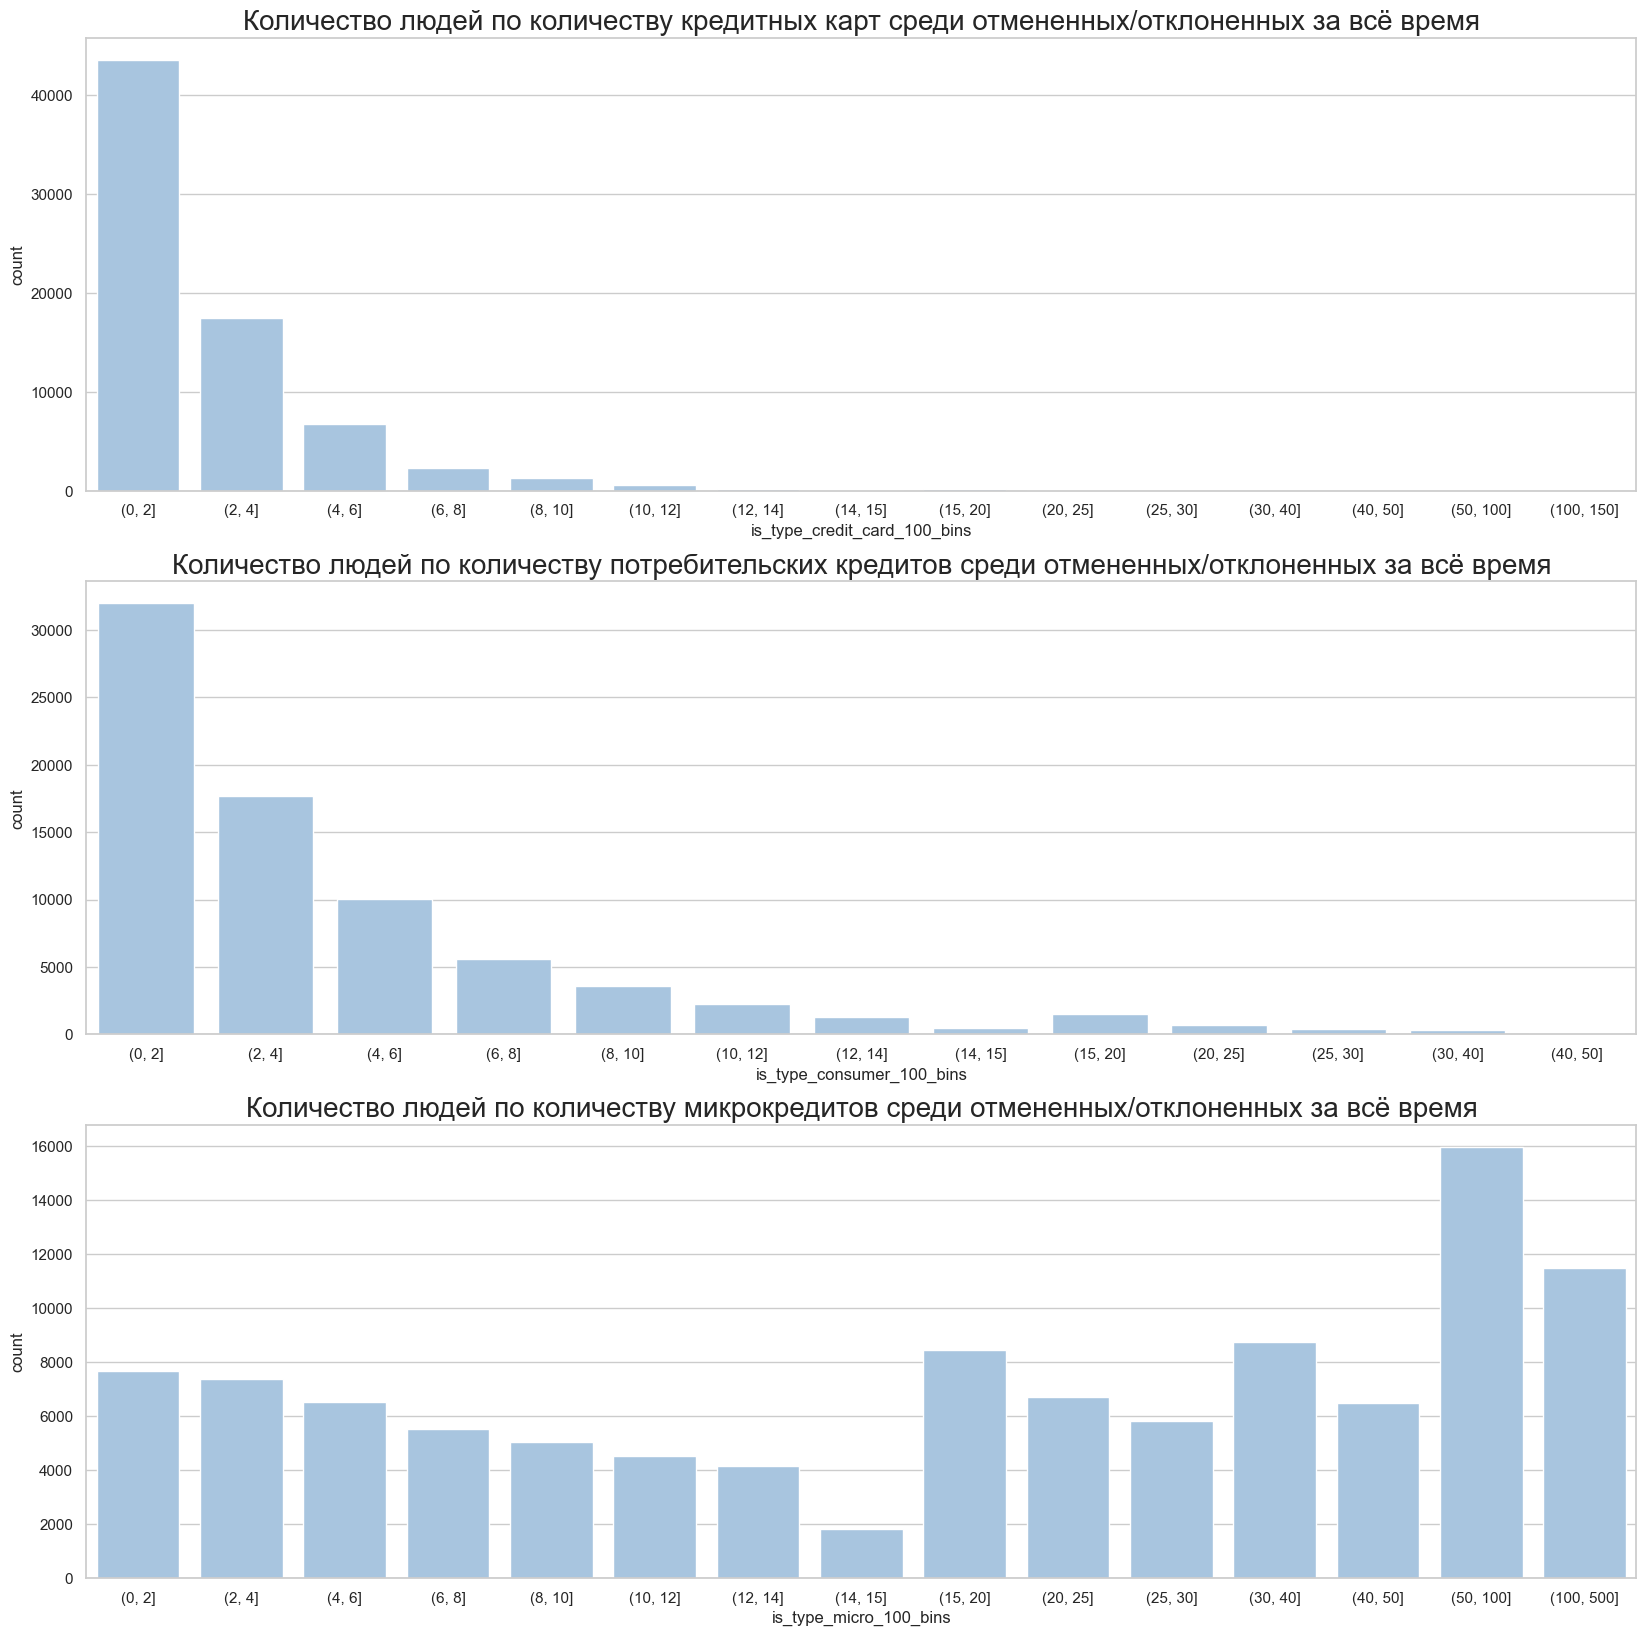

In [26]:
plt.figure(figsize=(20,20))

plt.subplot(3,1,1)
sns.countplot(data=df_for_grafic, x='is_type_credit_card_100_bins', palette=my_colors[1:2])
plt.title('Количество людей по количеству кредитных карт среди отмененных/отклоненных за всё время', size=20)

plt.subplot(3,1,2)
sns.countplot(data=df_for_grafic, x='is_type_consumer_100_bins', palette=my_colors[1:2])
plt.title('Количество людей по количеству потребительских кредитов среди отмененных/отклоненных за всё время', size=20)

plt.subplot(3,1,3)
sns.countplot(data=df_for_grafic, x='is_type_micro_100_bins', palette=my_colors[1:2])
plt.title('Количество людей по количеству микрокредитов среди отмененных/отклоненных за всё время', size=20)

Text(0.5, 1.0, 'Количество людей по количеству микрокредитов среди выданных за всё время')

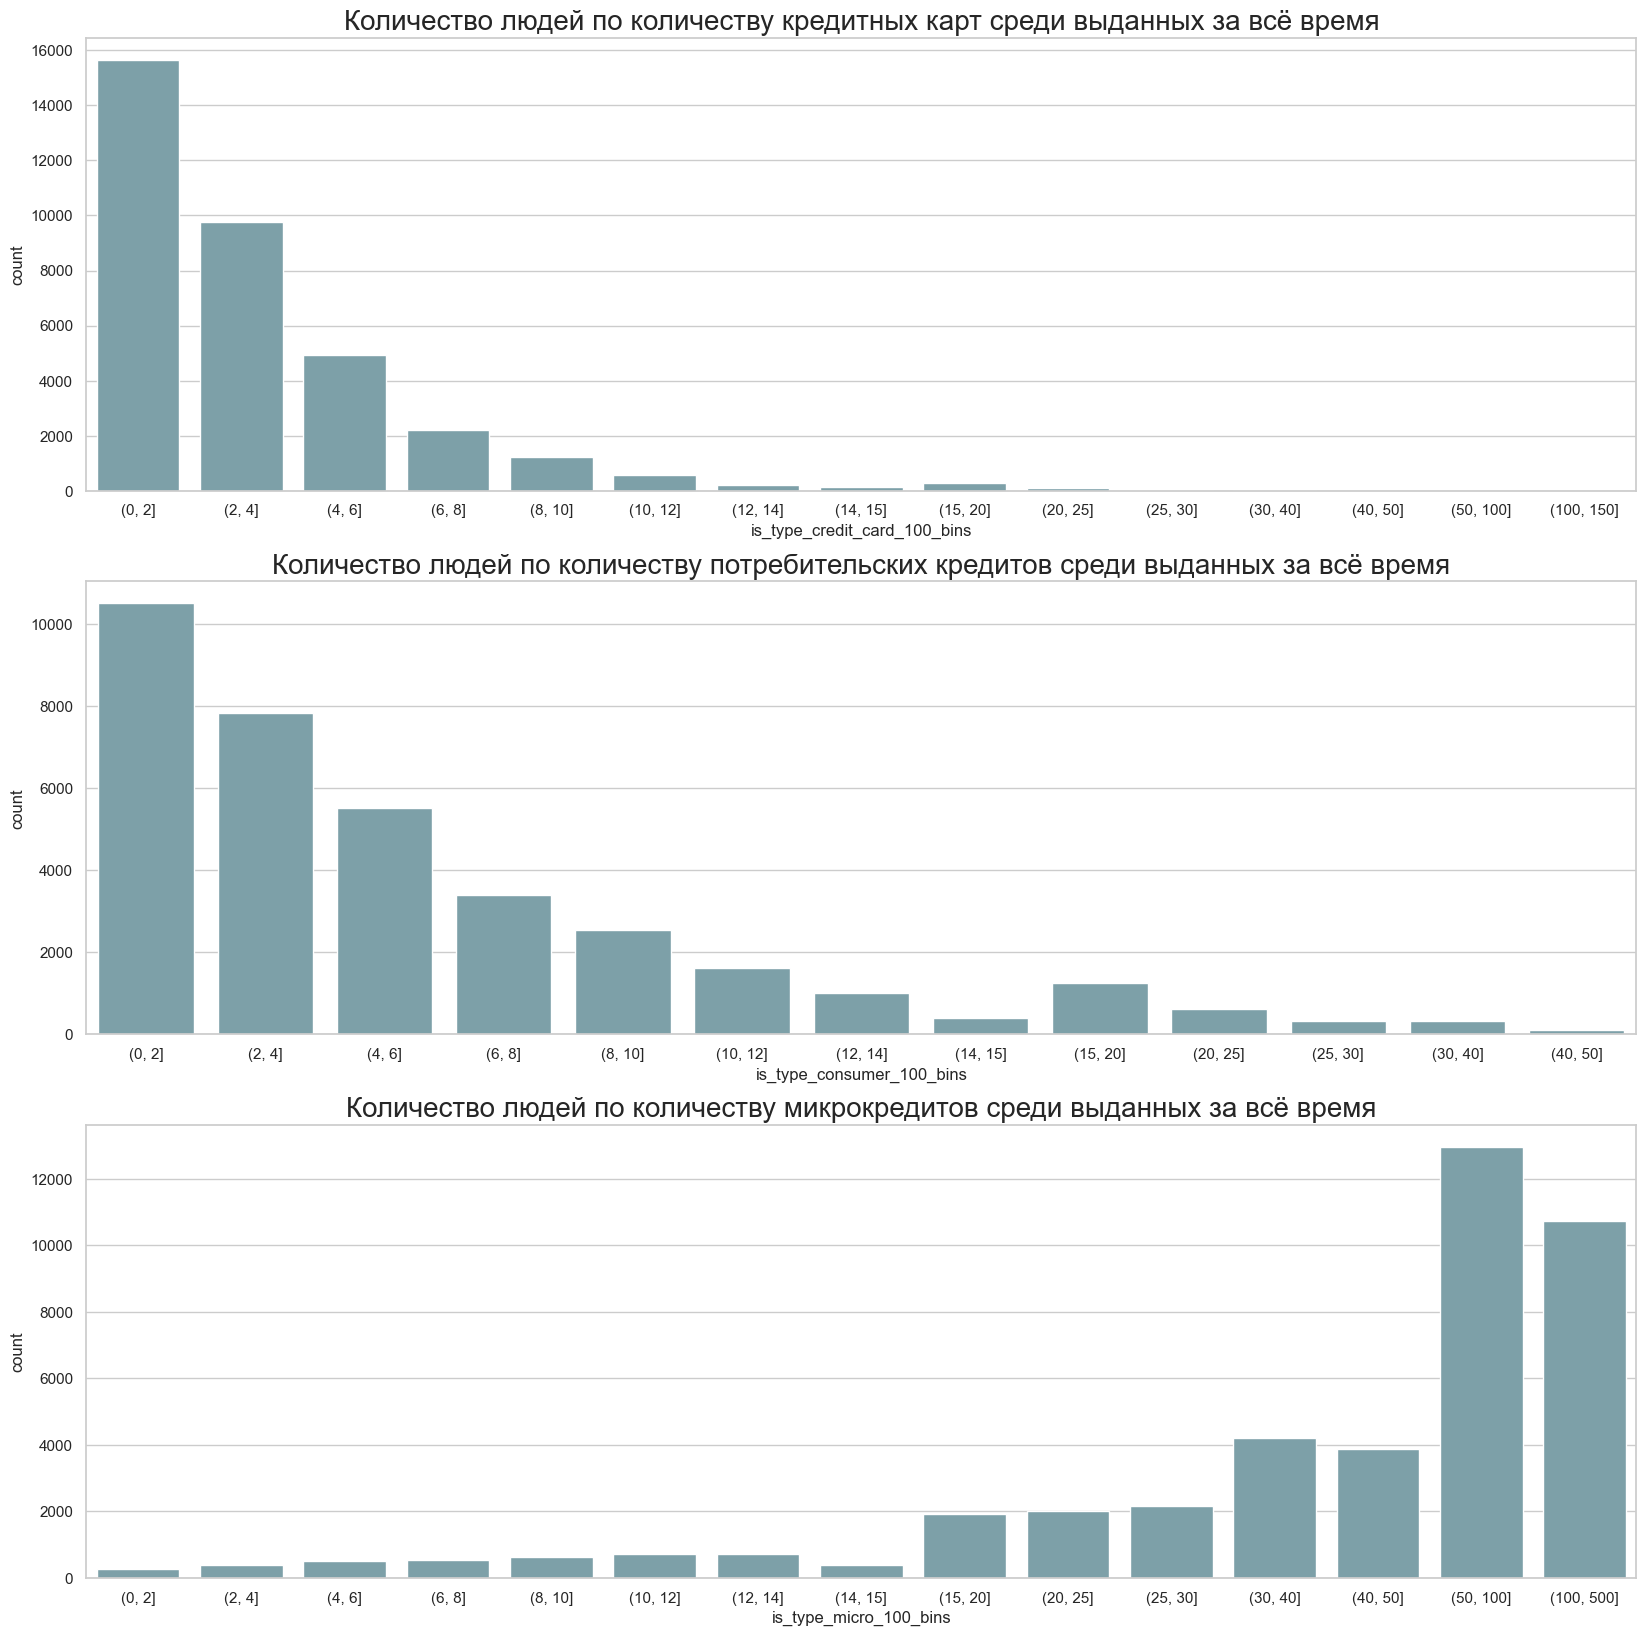

In [27]:
plt.figure(figsize=(20,20))

plt.subplot(3,1,1)
sns.countplot(data=df_prev_for_grafic, x='is_type_credit_card_100_bins', palette=my_colors[5:6])
plt.title('Количество людей по количеству кредитных карт среди выданных за всё время', size=20)

plt.subplot(3,1,2)
sns.countplot(data=df_prev_for_grafic, x='is_type_consumer_100_bins', palette=my_colors[5:6])
plt.title('Количество людей по количеству потребительских кредитов среди выданных за всё время', size=20)

plt.subplot(3,1,3)
sns.countplot(data=df_prev_for_grafic, x='is_type_micro_100_bins', palette=my_colors[5:6])
plt.title('Количество людей по количеству микрокредитов среди выданных за всё время', size=20)

## В основном, за все время, оформляют:
- до 2 кредитных карт  
- до 2 потребительских кредитов
- 50 - 100 микрокредитов 


Text(0.5, 1.0, 'Количество возвращенных/невозвращенных по кредитным картам за всё время')

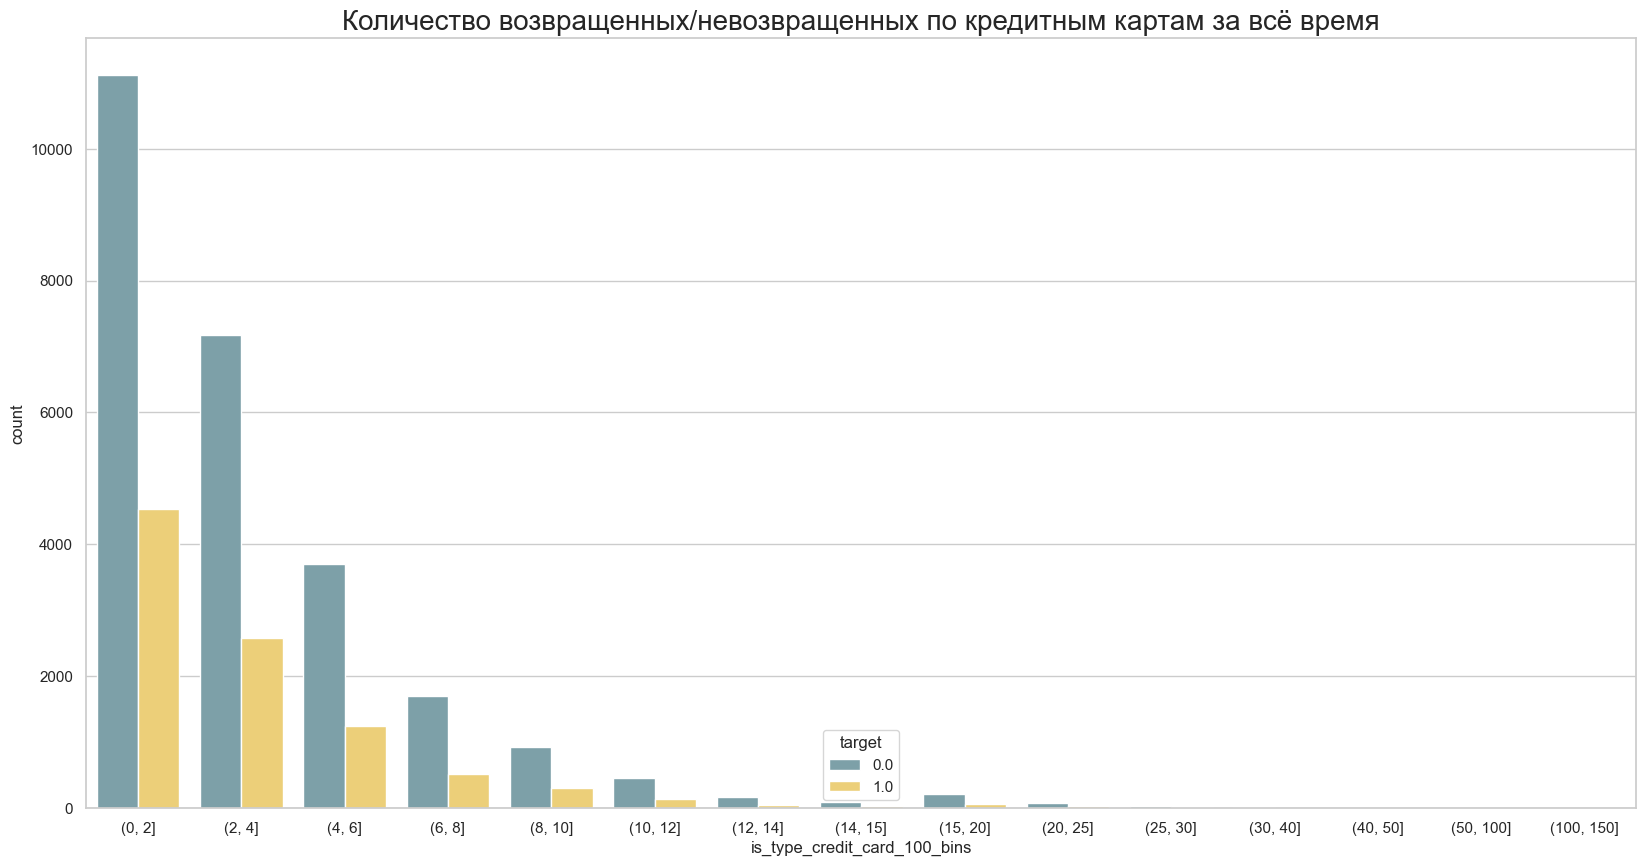

In [28]:
sns.countplot(data=df_prev_for_grafic, x='is_type_credit_card_100_bins', hue = 'target', palette=my_colors[5:7])
plt.title('Количество возвращенных/невозвращенных по кредитным картам за всё время', size=20)

Text(0.5, 1.0, 'Количество возвращенных/невозвращенных по потребительским кредитам за всё время')

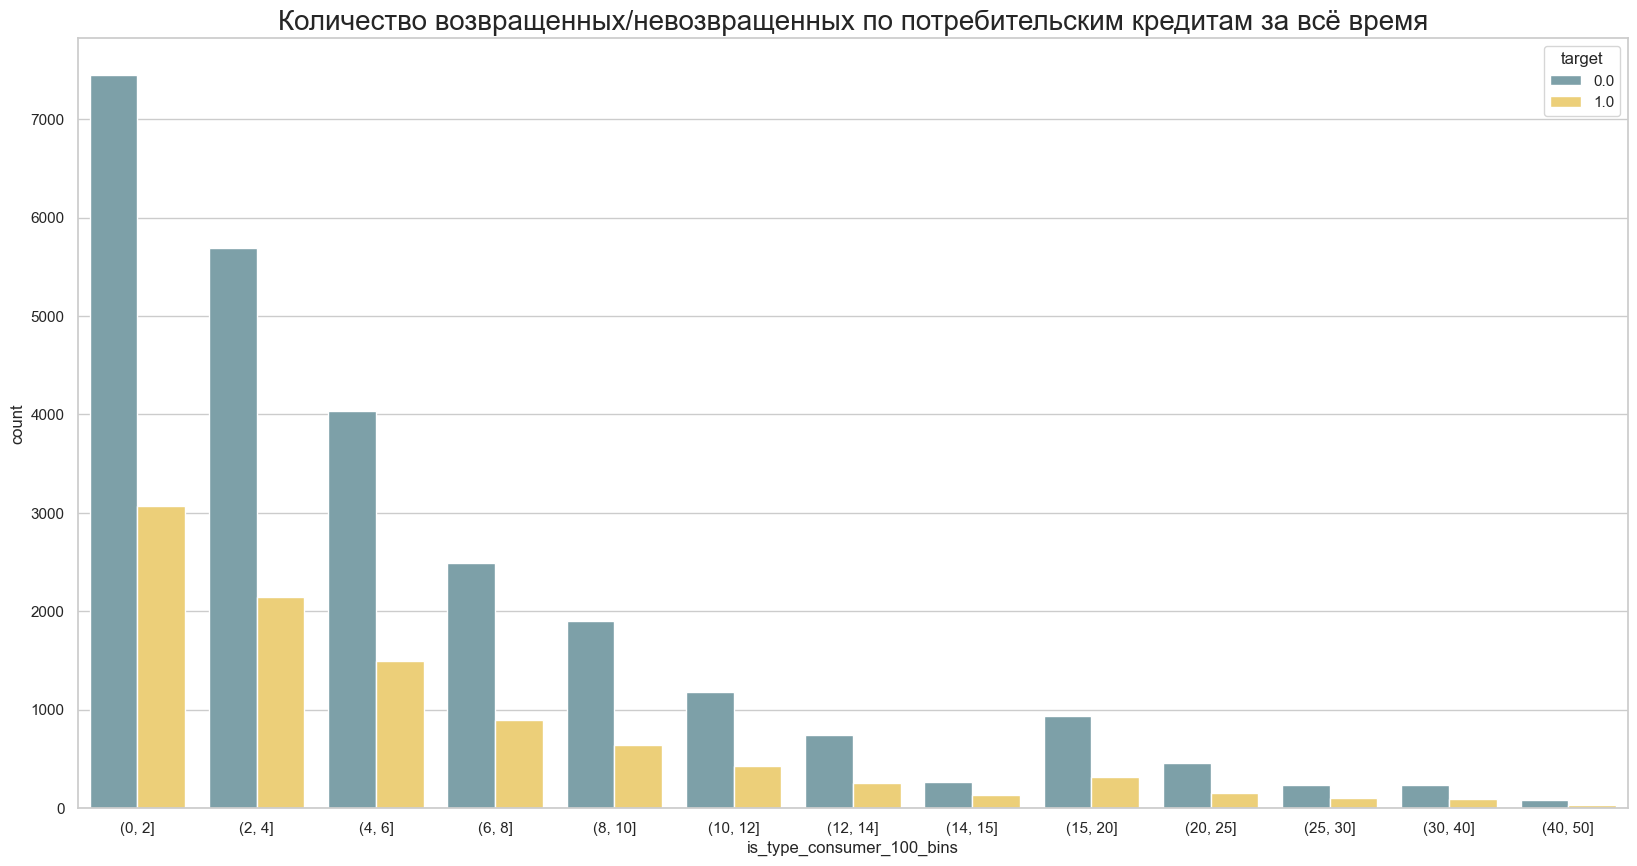

In [29]:
sns.countplot(data=df_prev_for_grafic, x='is_type_consumer_100_bins', hue = 'target', palette=my_colors[5:7])
plt.title('Количество возвращенных/невозвращенных по потребительским кредитам за всё время', size=20)

Text(0.5, 1.0, 'Количество возвращенных/невозвращенных по микрокредитам за всё время')

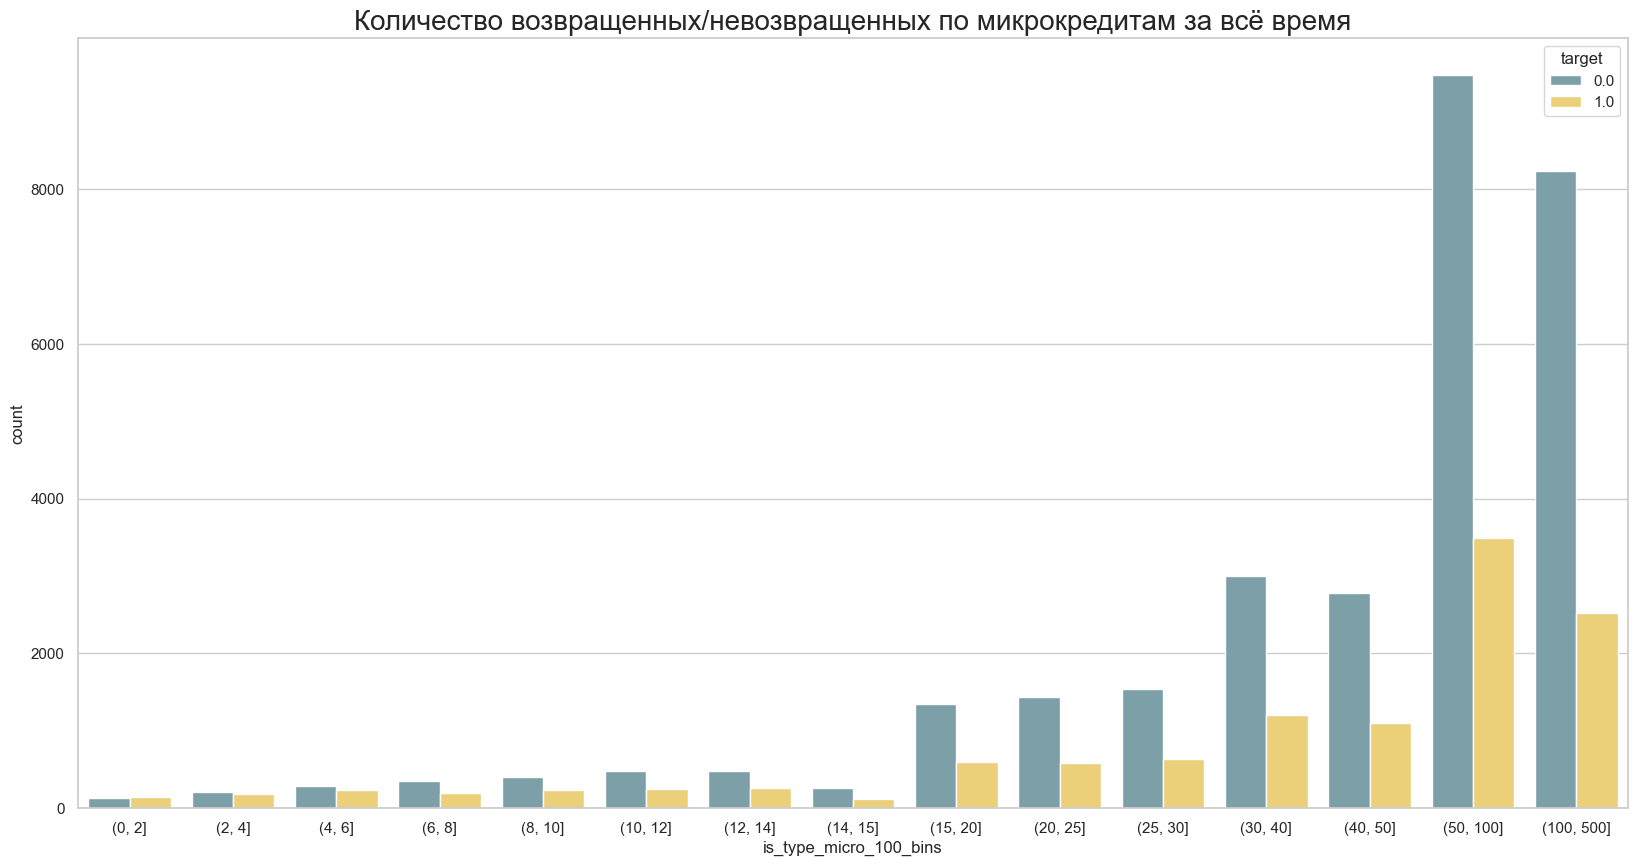

In [30]:
sns.countplot(data=df_prev_for_grafic, x='is_type_micro_100_bins', hue = 'target', palette=my_colors[5:7])
plt.title('Количество возвращенных/невозвращенных по микрокредитам за всё время', size=20)

## Преобладает дефолт по кредитным картам, далее микрокредиты
Но те кто оформляют 0-6 микрокредитов практически всегда не возвращают

In [25]:
sum_types_credits_bins = [0,2,4,6,8,10,12,14,15,20,25,30,40,50,100, 200, 400, 500, 600, 1000, 2500]

df_prev_for_grafic['count_all_credits_bins'] = pd.cut(df_prev_for_grafic['count_all_credits'], bins=sum_types_credits_bins)

Text(0.5, 1.0, 'Общее количество кредитов среди выданных за всё время')

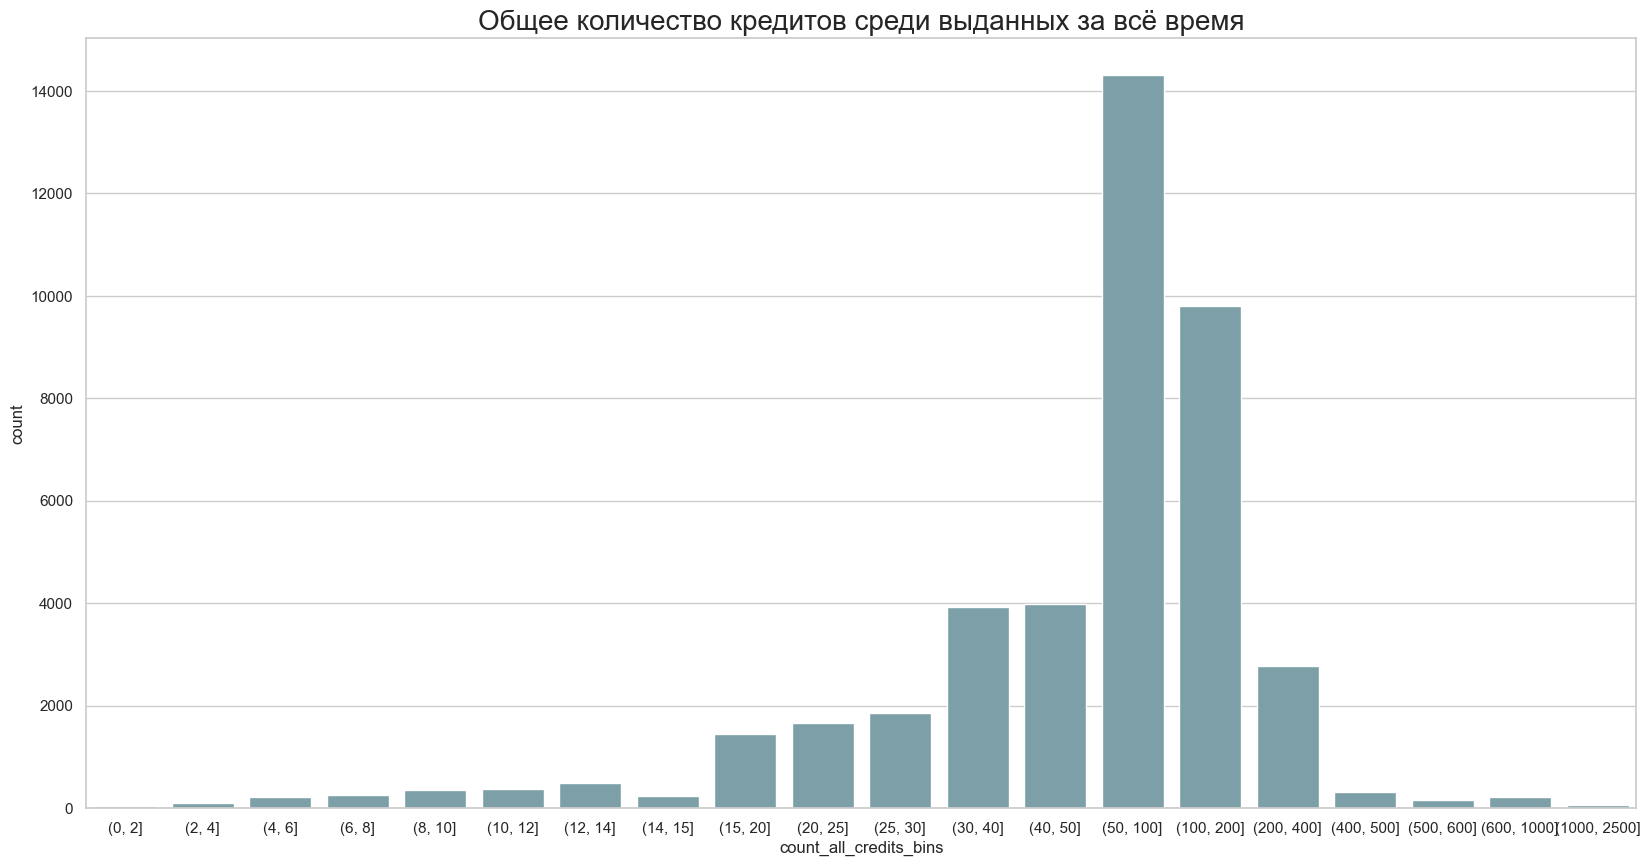

In [32]:
sns.countplot(data=df_prev_for_grafic, x='count_all_credits_bins', palette=my_colors[5:6])
plt.title('Общее количество кредитов среди выданных за всё время', size=20)

## Чаще всего берут 50-100 кредитов разных видов, при этом те кто берет кредитные карты и потребительский кредит, чаще всего берут много микрокредитов

Text(0.5, 1.0, 'Количество возвращенных/невозвращенных по кличеству кредитов за всё время')

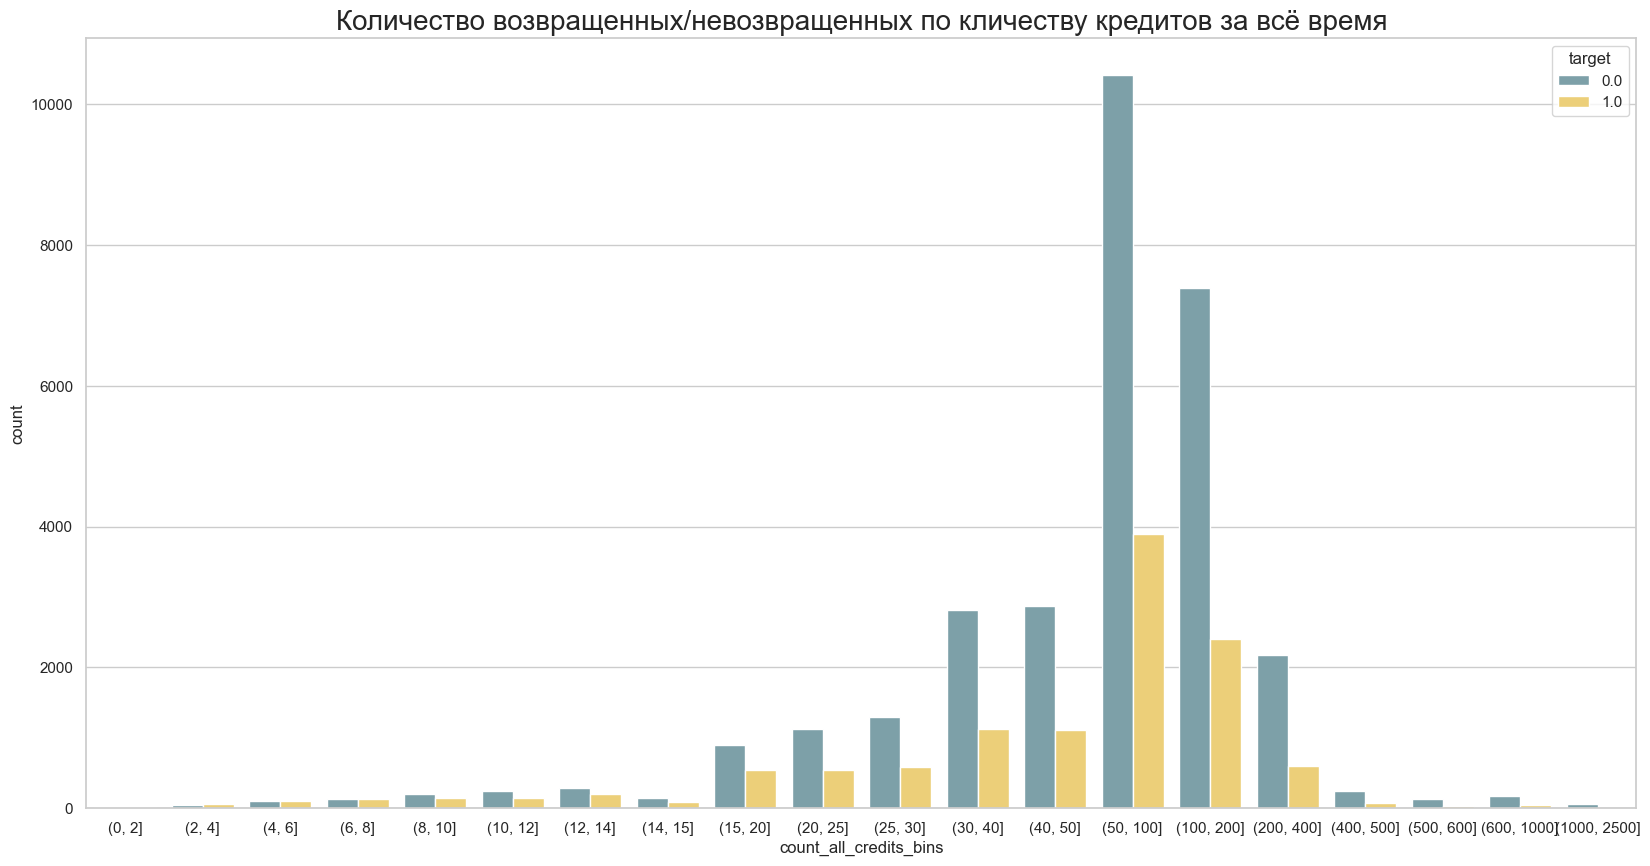

In [33]:
sns.countplot(data=df_prev_for_grafic, x='count_all_credits_bins', hue = 'target', palette=my_colors[5:7])
plt.title('Количество возвращенных/невозвращенных по кличеству кредитов за всё время', size=20)

## как в распределении с микрокредитами больше всего вероятность невернуть у тех кто берет 2-6 (возможно набирают из разных банков)

Text(0.5, 1.0, 'Активная сумма кредитов, взятых за последние 12 месяцев среди выданных')

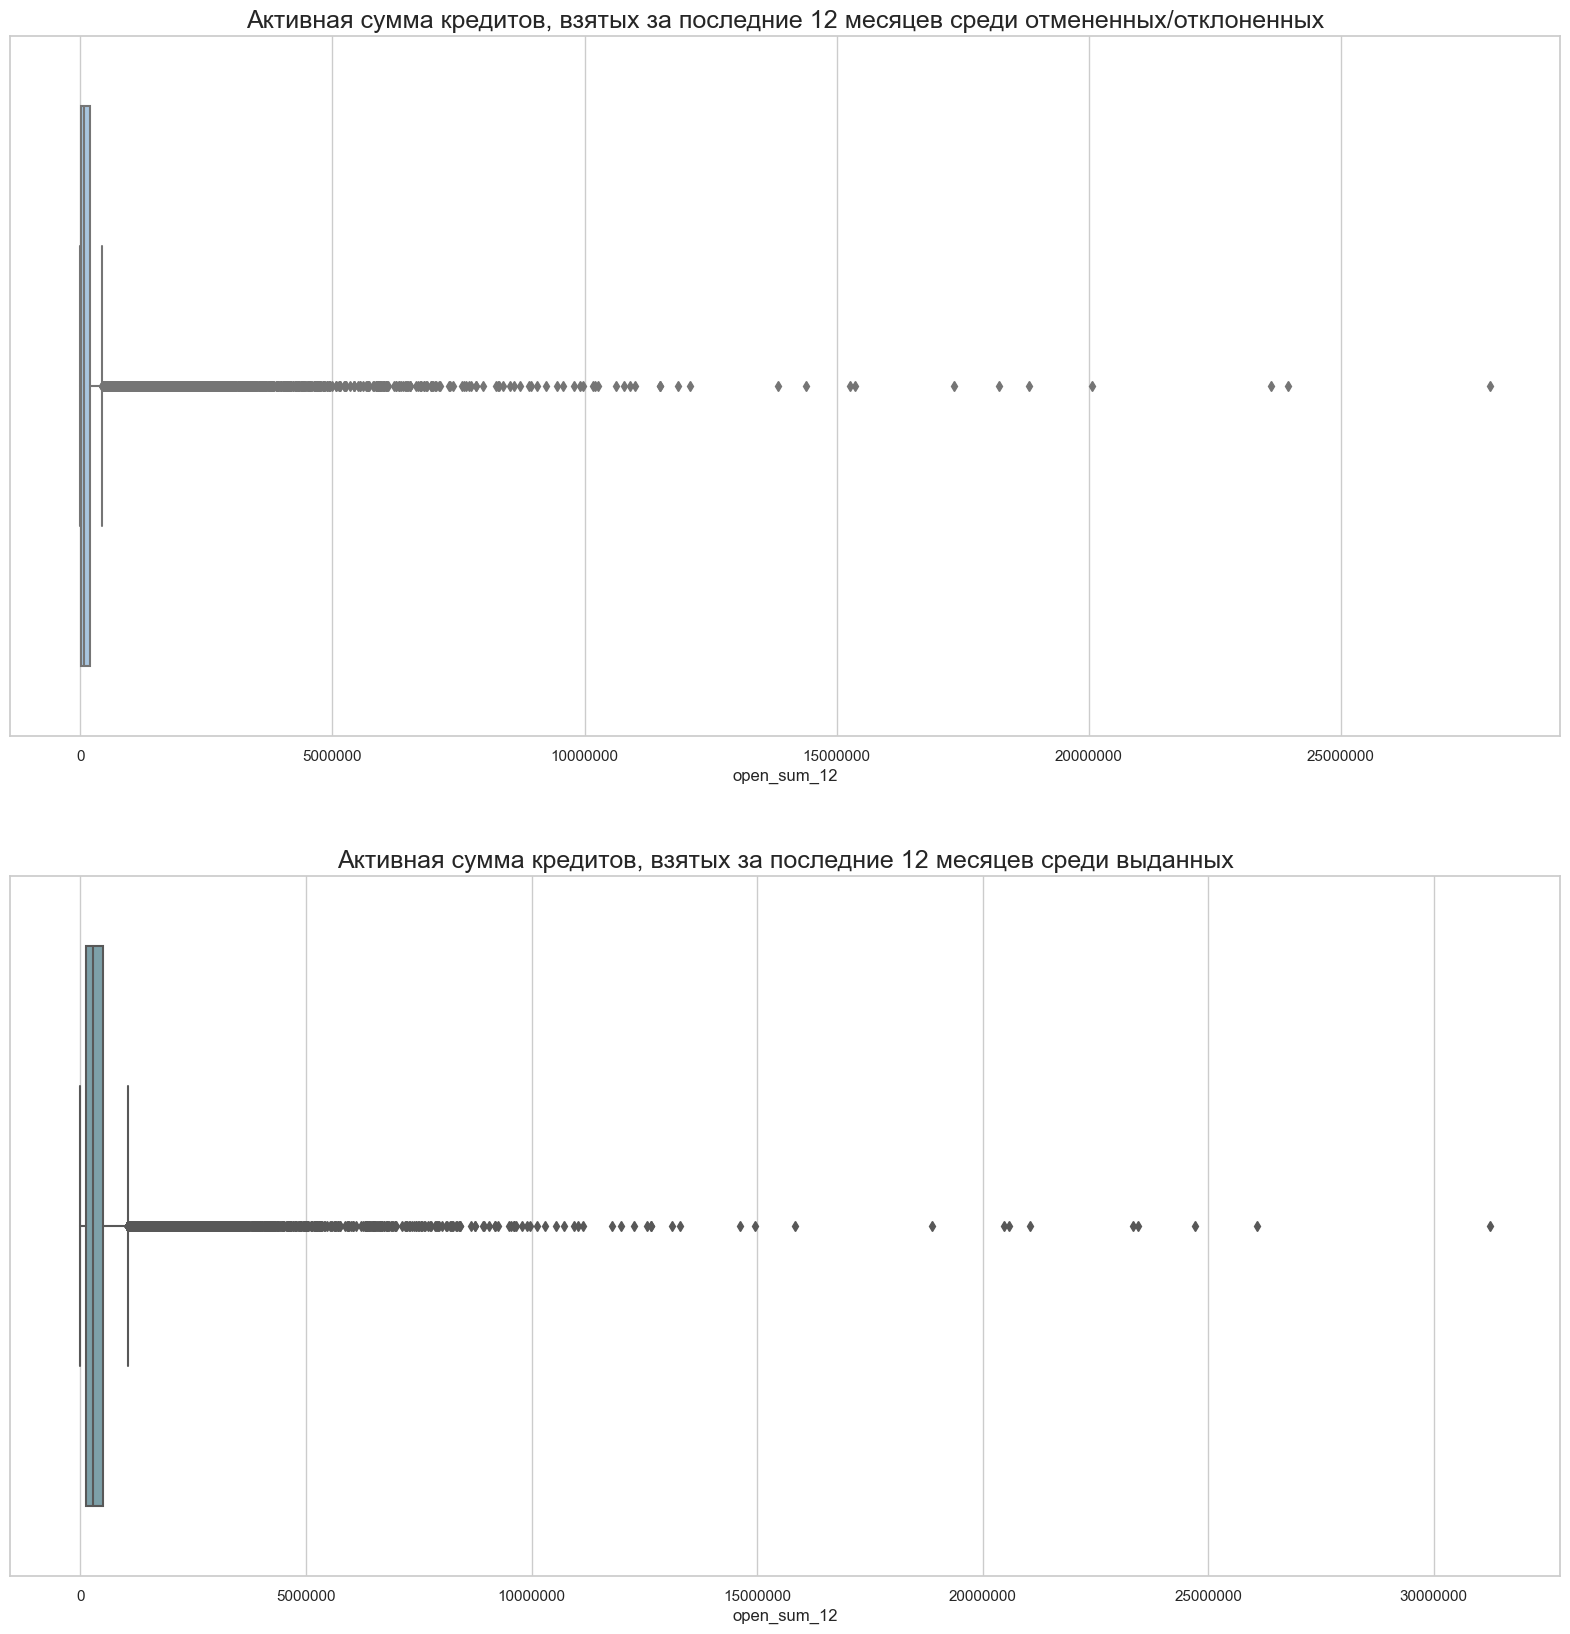

In [34]:
plt.figure(figsize=(20,20))

plt.subplot(2,1,1)
ax = sns.boxplot(data=data, x='open_sum_12', color=my_colors[1])
plt.ticklabel_format(style='plain', axis='x')
plt.title('Активная сумма кредитов, взятых за последние 12 месяцев среди отмененных/отклоненных', fontsize=18)

plt.subplot(2,1,2)
ax = sns.boxplot(data=data_prev, x='open_sum_12', color=my_colors[5])
plt.ticklabel_format(style='plain', axis='x')
plt.title('Активная сумма кредитов, взятых за последние 12 месяцев среди выданных', fontsize=18)

Text(0.5, 1.0, 'Активная сумма кредитов, взятых за последние 12 месяцев среди выданных')

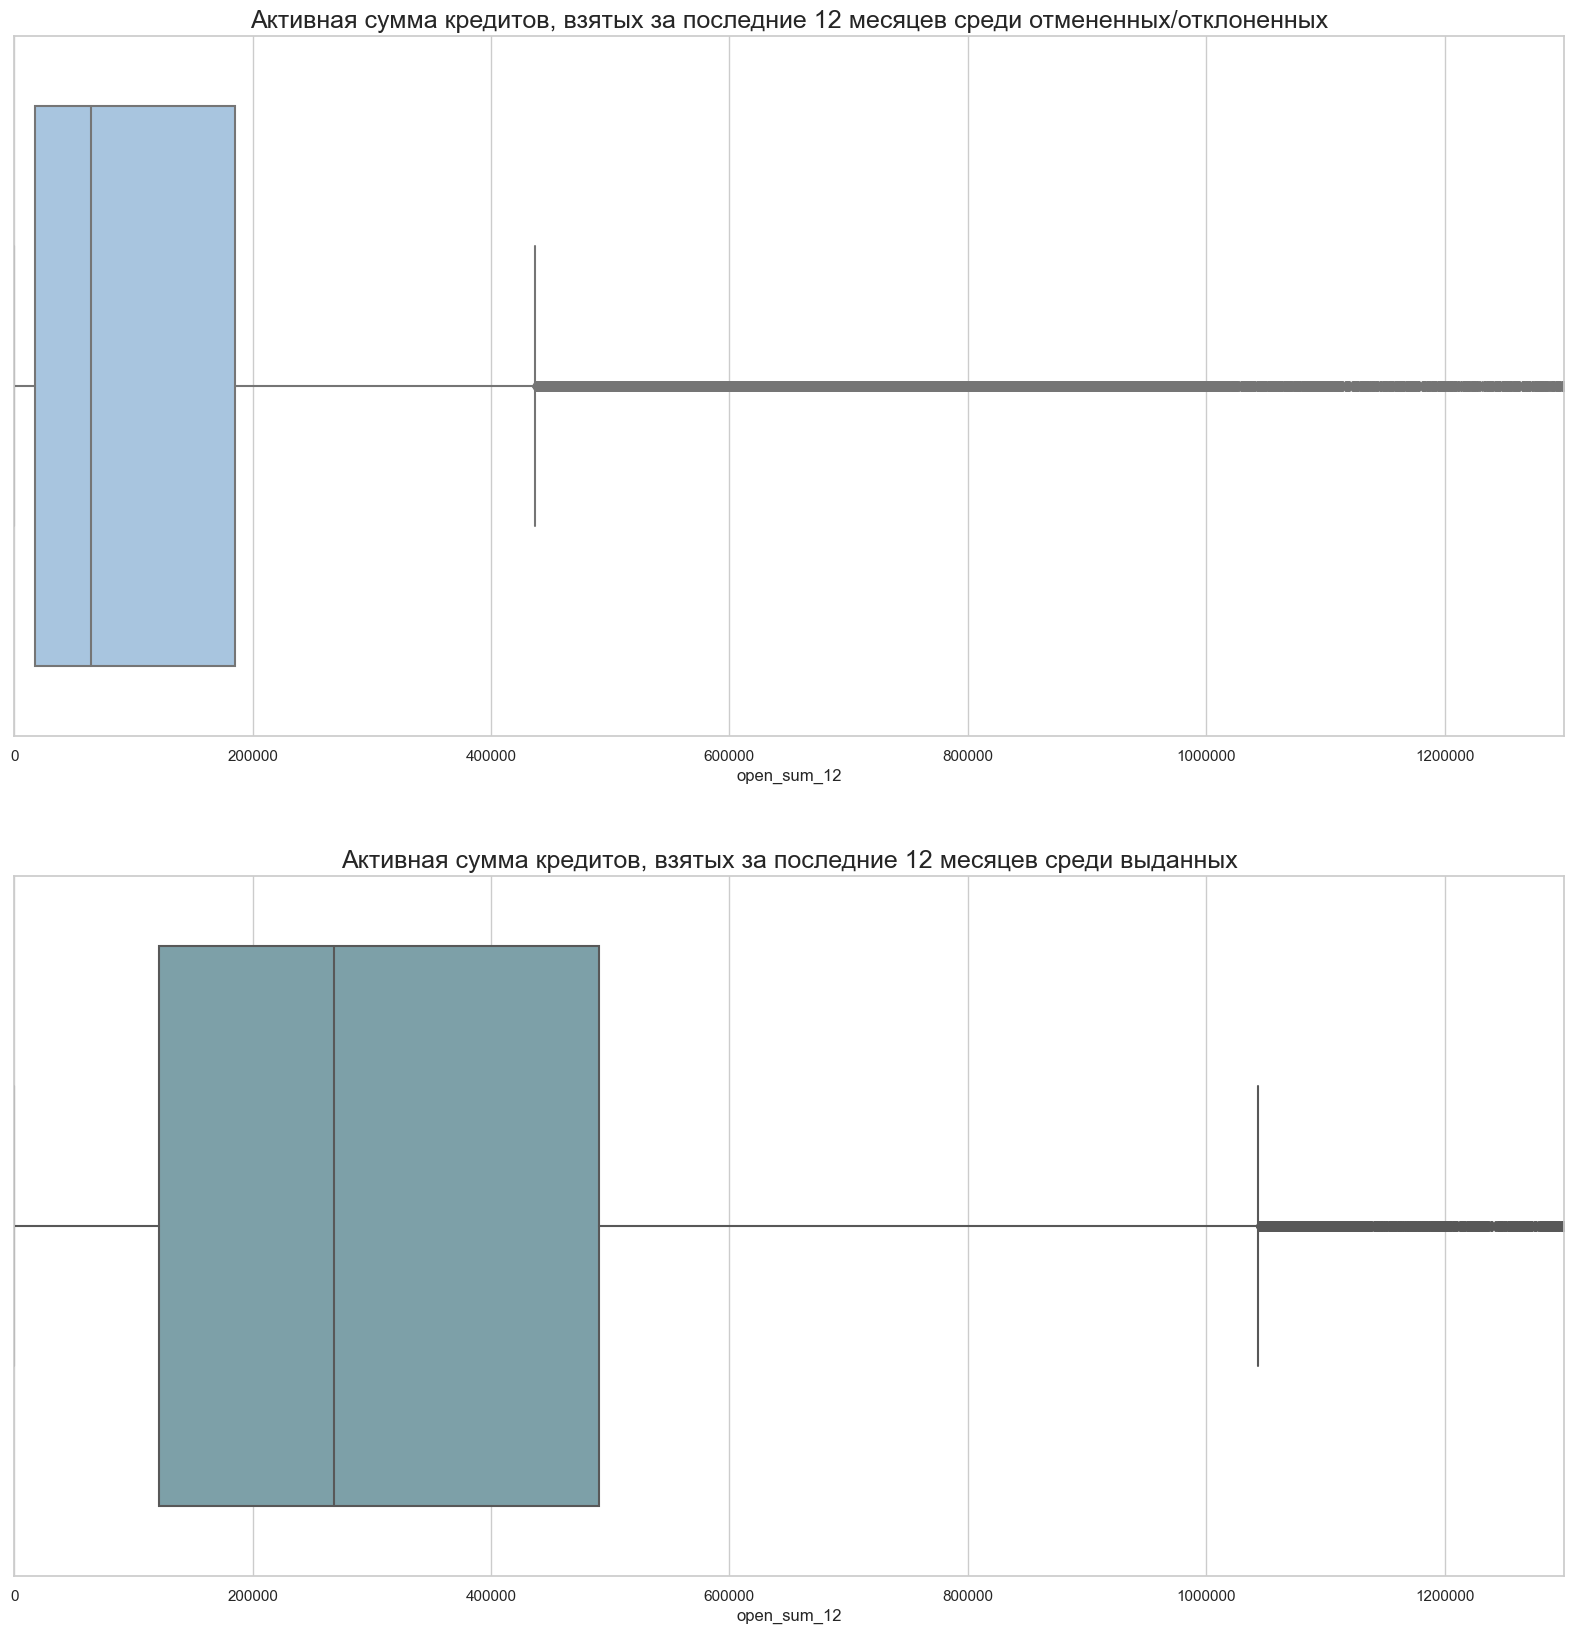

In [35]:
plt.figure(figsize=(20,20))

plt.subplot(2,1,1)
ax = sns.boxplot(data=data, x='open_sum_12', color=my_colors[1])
ax.set_xlim(0, data_prev['open_sum_12'].quantile(0.95))
plt.ticklabel_format(style='plain', axis='x')
plt.title('Активная сумма кредитов, взятых за последние 12 месяцев среди отмененных/отклоненных', fontsize=18)

plt.subplot(2,1,2)
ax = sns.boxplot(data=data_prev, x='open_sum_12', color=my_colors[5])
ax.set_xlim(0, data_prev['open_sum_12'].quantile(0.95))
plt.ticklabel_format(style='plain', axis='x')
plt.title('Активная сумма кредитов, взятых за последние 12 месяцев среди выданных', fontsize=18)

Text(0.5, 1.0, 'Средняя просрочка за всё время (с лагом по времени в 2 месяца) среди выданных')

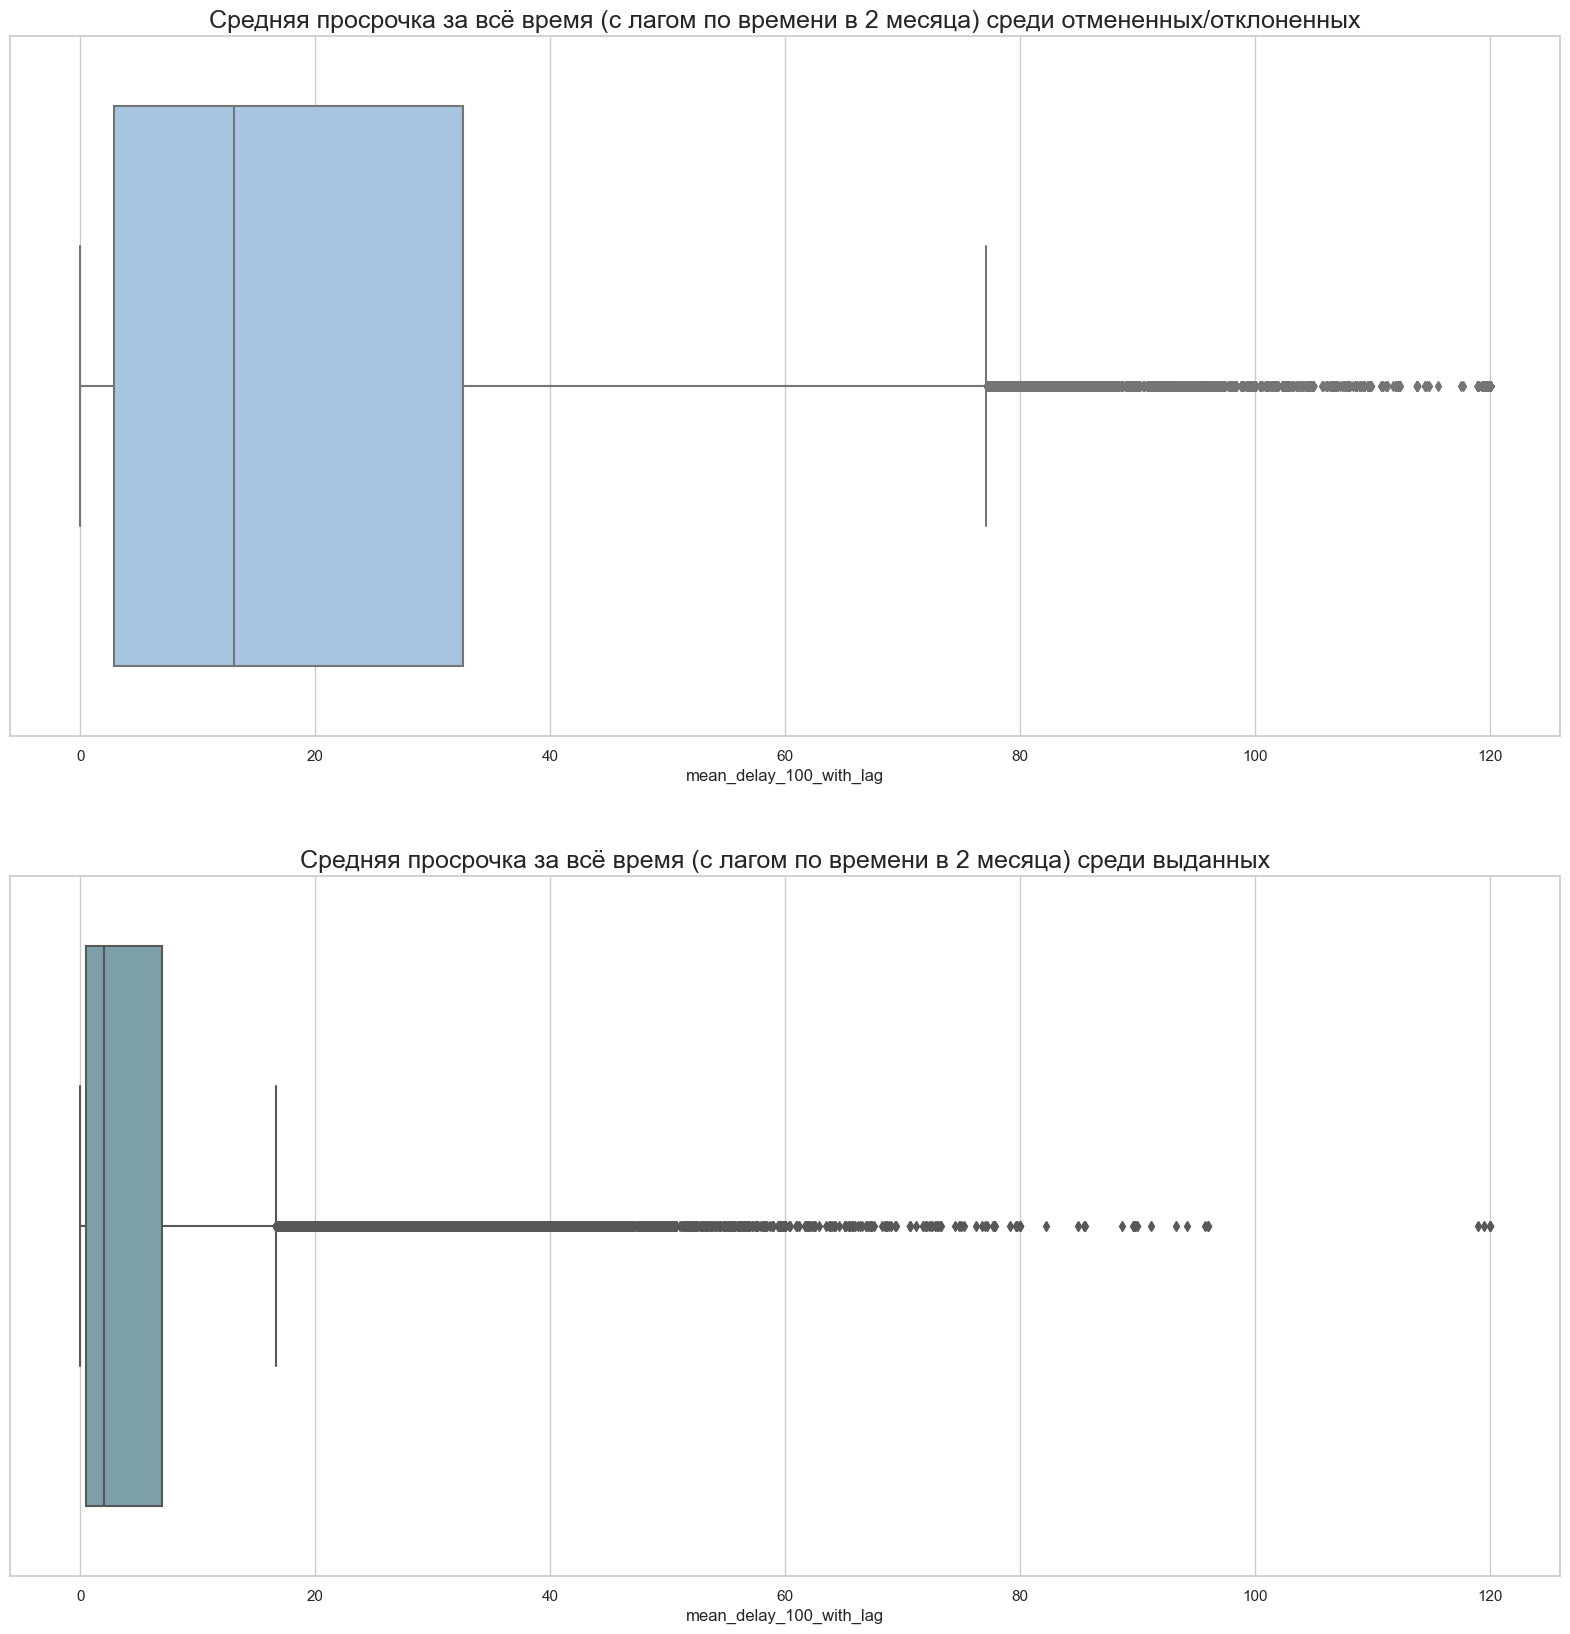

In [36]:
plt.figure(figsize=(20,20))

plt.subplot(2,1,1)
ax = sns.boxplot(data=data, x='mean_delay_100_with_lag', color=my_colors[1])
#ax.set_xlim(0, data_prev['open_sum_12'].quantile(0.95))
plt.ticklabel_format(style='plain', axis='x')
plt.title('Средняя просрочка за всё время (с лагом по времени в 2 месяца) среди отмененных/отклоненных', fontsize=18)

plt.subplot(2,1,2)
ax = sns.boxplot(data=data_prev, x='mean_delay_100_with_lag', color=my_colors[5])
#ax.set_xlim(0, data_prev['open_sum_12'].quantile(0.95))
plt.ticklabel_format(style='plain', axis='x')
plt.title('Средняя просрочка за всё время (с лагом по времени в 2 месяца) среди выданных', fontsize=18)

<AxesSubplot: >

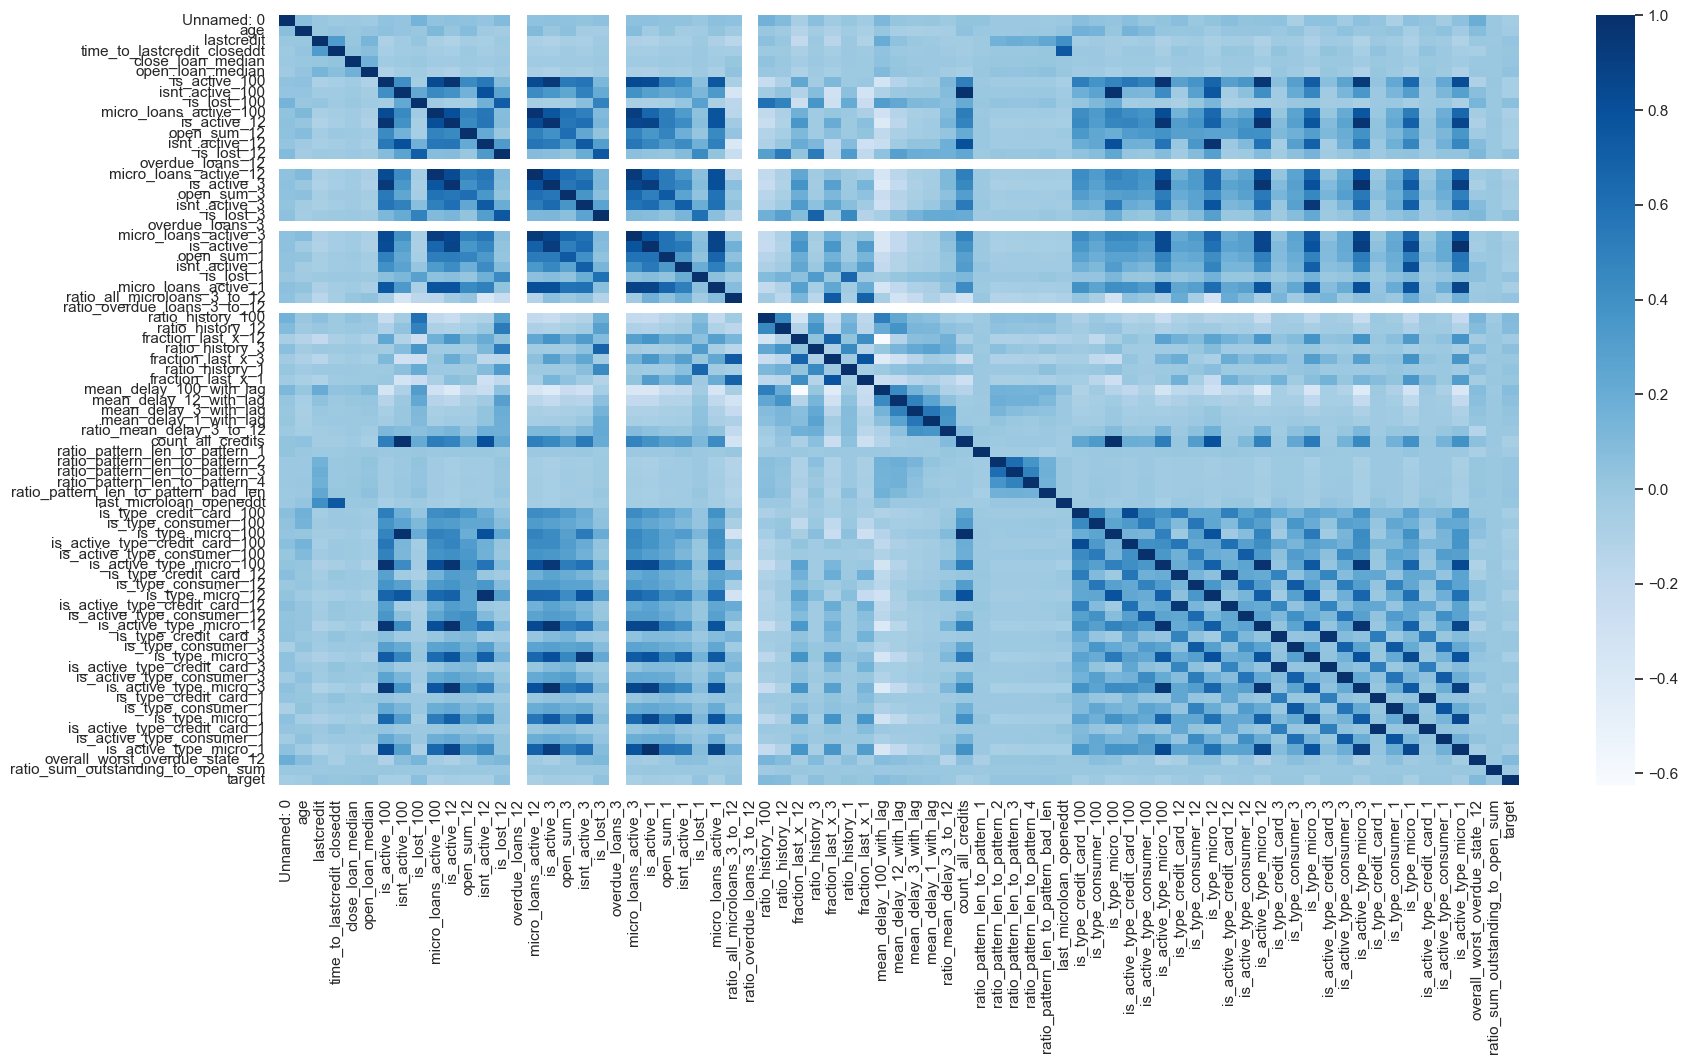

In [213]:
sns.heatmap(data_prev.corr(),
            xticklabels=corr1.columns,
            yticklabels=corr1.columns,
            cmap ="Blues")

In [300]:
#sns.pairplot(data)

In [397]:
data_prev.corr()

,Unnamed: 0,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,is_lost_100,micro_loans_active_100,is_active_12,open_sum_12,isnt_active_12,is_lost_12,overdue_loans_12,micro_loans_active_12,is_active_3,open_sum_3,isnt_active_3,is_lost_3,overdue_loans_3,micro_loans_active_3,is_active_1,open_sum_1,isnt_active_1,is_lost_1,micro_loans_active_1,ratio_all_microloans_3_to_12,ratio_overdue_loans_3_to_12,ratio_history_100,ratio_history_12,fraction_last_x_12,ratio_history_3,fraction_last_x_3,ratio_history_1,fraction_last_x_1,mean_delay_100_with_lag,...,ratio_pattern_len_to_pattern_2,ratio_pattern_len_to_pattern_3,ratio_pattern_len_to_pattern_4,ratio_pattern_len_to_pattern_bad_len,last_microloan_openeddt,is_type_credit_card_100,is_type_consumer_100,is_type_micro_100,is_active_type_credit_card_100,is_active_type_consumer_100,is_active_type_micro_100,is_type_credit_card_12,is_type_consumer_12,is_type_micro_12,is_active_type_credit_card_12,is_active_type_consumer_12,is_active_type_micro_12,is_type_credit_card_3,is_type_consumer_3,is_type_micro_3,is_active_type_credit_card_3,is_active_type_consumer_3,is_active_type_micro_3,is_type_credit_card_1,is_type_consumer_1,is_type_micro_1,is_active_type_credit_card_1,is_active_type_consumer_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum,target,age_bins,is_type_credit_card_100_bins,is_type_consumer_100_bins,is_type_micro_100_bins,open_sum_12_bins
Unnamed: 0,1.000000,0.070763,0.008611,-0.013536,-0.006729,-0.016232,0.039440,0.027560,0.143092,0.038367,0.047952,0.043983,0.028061,0.092034,NaN,0.045335,0.048623,0.042080,0.034667,0.047806,NaN,0.052540,0.050602,0.040079,0.039435,0.006793,0.056074,0.047407,NaN,0.155901,0.092694,-0.064965,0.065679,-0.025389,0.013237,-0.022784,0.113257,...,-0.008471,-0.006478,-0.007740,-0.014345,-0.003658,0.070830,0.038417,0.026446,0.063096,0.014514,0.031791,0.066826,0.000491,0.033225,0.072002,0.030470,0.040722,0.045732,-0.067049,0.045237,0.045435,-0.027206,0.048577,0.023947,-0.080296,0.050152,0.023962,-0.041107,0.052192,0.191021,-0.001524,-0.043098,0.068636,0.085339,0.041596,-0.016649,0.044000
age,0.070763,1.000000,0.005036,0.023229,0.004518,0.024368,0.052928,0.023826,0.004209,0.106256,0.021487,0.075305,-0.016879,-0.036564,NaN,0.100834,0.006741,0.057458,-0.040095,-0.046064,NaN,0.075865,-0.026070,0.031197,-0.039611,-0.030947,0.033251,-0.020869,NaN,0.006065,-0.021954,-0.128009,-0.037037,-0.088645,-0.026934,-0.071246,0.009467,...,-0.008553,-0.009107,-0.000887,-0.008197,0.022303,0.163687,0.146124,0.015760,0.143019,0.099281,0.020284,0.011545,0.020791,-0.020199,0.021295,0.019280,0.018578,-0.000033,0.032302,-0.039639,0.001206,0.041511,0.004720,0.012541,0.031248,-0.051690,0.011688,0.041868,-0.028574,0.076419,-0.000047,-0.028911,0.987369,0.167037,0.171470,-0.031241,0.075405
lastcredit,0.008611,0.005036,1.000000,0.321316,0.014589,0.136632,-0.090479,-0.029996,0.017041,-0.070244,-0.105785,-0.044085,-0.057001,-0.011257,NaN,-0.081190,-0.110153,-0.060446,-0.068736,-0.016664,NaN,-0.090230,-0.107828,-0.060988,-0.056306,-0.010416,-0.090387,-0.161181,NaN,0.057150,0.007822,-0.203315,-0.003977,-0.146034,-0.004256,-0.110607,0.206255,...,0.157834,0.188807,0.168683,0.233287,0.400874,-0.043448,-0.018069,-0.038605,-0.050196,-0.031193,-0.090374,-0.041769,-0.034329,-0.071729,-0.041601,-0.036740,-0.104113,-0.019730,-0.028378,-0.089004,-0.019572,-0.027251,-0.109563,-0.009163,-0.024368,-0.091408,-0.009314,-0.022037,-0.107579,-0.000209,-0.004212,0.026328,0.005763,-0.042409,-0.023071,-0.152010,-0.043805
time_to_lastcredit_closeddt,-0.013536,0.023229,0.321316,1.000000,0.034549,0.069557,-0.055367,-0.031694,-0.019157,-0.046114,-0.056132,-0.006134,-0.041470,-0.016078,NaN,-0.049446,-0.056885,-0.021775,-0.045474,-0.014546,NaN,-0.051061,-0.051923,-0.024606,-0.034838,-0.008084,-0.046387,-0.048894,NaN,-0.014288,-0.012045,-0.084775,-0.012304,-0.051637,-0.007062,-0.018061,0.036446,...,0.000911,0.001960,0.002106,0.011605,0.751

# Предобработка

In [55]:
data2 = data.copy()
data_prev2 = data_prev.copy()

In [56]:
data2.replace([np.inf, -np.inf], 100, inplace=True)
data_prev2.replace([np.inf, -np.inf], 100, inplace=True)

In [57]:
imputer = IterativeImputer()
def fill_nan(df, columns):
    for col in columns:
        df[col] = imputer.fit_transform(df[[col]])
    return df

In [58]:
data2 = fill_nan(data2, lost_col_data)
data_prev2 = fill_nan(data_prev2, lost_col_data_prev)

In [85]:
#def log_normalize(df):
#    for col in df.columns:
#        df[col] = np.log(df[col])
#    return df
        

In [59]:
def IQR_method(df,n,columns):
    """
    Принимает датафрейм и возвращает список индексов, соответствующий наблюдениям.
    содержащий более n выбросов согласно методу Tukey IQR.
    """
    outlier_list = []
    
    for col in columns:
        
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col],75)
       
        IQR = Q3 - Q1
        
        #делаю не 1,5 тк выбросы отличительная черта и много отрезается, что плохо сказывается на предсказаниях
        outlier_step = 3 * IQR          
        outlier_list_column = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        outlier_list.extend(outlier_list_column)
        
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    out1 = df[df[col] < Q1 - outlier_step]
    out2 = df[df[col] > Q3 + outlier_step]
    
    print('Общее количество удаляемых выбросов:', out1.shape[0]+out2.shape[0])
    
    return multiple_outliers

In [60]:
columns_with_out = ['lastcredit', 'time_to_lastcredit_closeddt', 'close_loan_median', 'open_loan_median', 'isnt_active_100',\
                    'micro_loans_active_100', 'open_sum_12', 'isnt_active_12', 'micro_loans_active_12', 'open_sum_3', \
                    'micro_loans_active_3', 'open_sum_1', 'micro_loans_active_1', 'mean_delay_100_with_lag', \
                    'mean_delay_12_with_lag', 'mean_delay_3_with_lag', 'count_all_credits', 'last_microloan_openeddt',\
                    'is_type_consumer_100', 'is_type_micro_100', 'is_active_type_credit_card_100', 'is_active_type_consumer_100', \
                   'is_active_type_micro_100', 'is_active_type_micro_100', 'is_type_credit_card_12',\
                    'is_type_consumer_12', 'is_type_micro_12', 'is_active_type_credit_card_12', \
                    'is_active_type_consumer_12', 'is_active_type_micro_12', 'is_type_credit_card_3', \
                    'is_type_consumer_3', 'is_type_micro_3', 'is_active_type_credit_card_3', 'is_active_type_consumer_3',\
                    'is_active_type_micro_3', 'is_type_credit_card_1', 'is_type_consumer_1', 'is_type_micro_1', \
                    'is_active_type_credit_card_1', 'is_active_type_consumer_1', 'is_active_type_micro_1',\
                    'ratio_sum_outstanding_to_open_sum']

In [61]:
Outliers_IQR = IQR_method(data_prev2,1,columns_with_out)

data_prev2 = data_prev2.drop(Outliers_IQR, axis = 0).reset_index(drop=True)

Общее количество удаляемых выбросов: 11640


In [62]:
features = ['overall_worst_overdue_state_12',
 'ratio_sum_outstanding_to_open_sum',
 'count_all_credits',
 'age',
 'isnt_active_100',
 'is_active_3',
 'fraction_last_x_12',
 'ratio_all_microloans_3_to_12',
 'micro_loans_active_100',
 'ratio_history_12',
 'isnt_active_3',
 'is_type_micro_100',
 'is_active_12',
 'isnt_active_12',
 'fraction_last_x_3',
 'open_sum_3',
 'micro_loans_active_12',
 'open_sum_12',
 'open_sum_1',
 'micro_loans_active_1',
 'mean_delay_1_with_lag',
 'ratio_history_3',
 'isnt_active_1',
 'mean_delay_12_with_lag',
 'mean_delay_100_with_lag',
 'is_type_credit_card_100',
 'micro_loans_active_3',
 'fraction_last_x_1',
 'is_type_consumer_100',
 'ratio_mean_delay_3_to_12',
 'is_active_type_micro_100',
 'is_active_type_micro_1',
 'ratio_history_100',
 'is_active_100',
 'is_type_micro_1',
 'open_loan_median',
 'open_sum_12_bins',
 'lastcredit',
 'count_all_credits_bins',
 'last_microloan_openeddt', 'count_all_credits_bins']

In [89]:
#feature

In [46]:
#data_prev2 = log_normalize(data_prev2)

In [47]:
#data_prev2.describe()

In [63]:
data_prev2.shape

(23318, 75)

In [64]:
#data_prev2['age_bins'] = np.searchsorted(age_bins, data_prev2.age.values, side='right')
#data2['age_bins'] = np.searchsorted(age_bins, data2.age.values, side='right')
#
#data_prev2['is_type_credit_card_100_bins'] = np.searchsorted(is_type_credit_card_100_bins, \
#                                                            data_prev2.is_type_credit_card_100.values, side='right')
#data2['is_type_credit_card_100_bins'] = np.searchsorted(is_type_credit_card_100_bins, \
#                                                       data2.is_type_credit_card_100.values, side='right')
#
data_prev2['is_type_consumer_100_bins'] = np.searchsorted(is_type_consumer_100_bins, \
                                                         data_prev2.is_type_consumer_100.values, side='right')
data2['is_type_consumer_100_bins'] = np.searchsorted(is_type_consumer_100_bins, \
                                                    data2.is_type_consumer_100.values, side='right')
#
#data_prev2['is_type_micro_100_bins'] = np.searchsorted(is_type_micro_100_bins, \
#                                                         data_prev2.is_type_micro_100.values, side='right')
#data2['is_type_micro_100_bins'] = np.searchsorted(is_type_micro_100_bins, \
#                                                    data2.is_type_micro_100.values, side='right')

data_prev2['count_all_credits_bins'] = np.searchsorted(sum_types_credits_bins, \
                                                         data_prev2.count_all_credits.values, side='right')
data2['count_all_credits_bins'] = np.searchsorted(sum_types_credits_bins, \
                                                    data2.count_all_credits.values, side='right')

In [65]:
open_sum_12_bins = range(0, 25000000, 10000)

data_prev2['open_sum_12_bins'] = np.searchsorted(open_sum_12_bins, \
                                                         data_prev2.open_sum_12.values, side='right')
data2['open_sum_12_bins'] = np.searchsorted(open_sum_12_bins, \
                                                    data2.open_sum_12.values, side='right')

In [66]:
data_prev2.describe().applymap(lambda x: f"{x:0.3f}")

,Unnamed: 0,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,is_lost_100,micro_loans_active_100,...,is_type_micro_1,is_active_type_credit_card_1,is_active_type_consumer_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum,target,is_type_consumer_100_bins,count_all_credits_bins,open_sum_12_bins
count,23318.000,23318.000,23318.000,23318.000,23318.000,23318.000,23318.000,23318.000,23318.000,23318.000,...,23318.000,23318.000,23318.000,23318.000,23318.000,23318.000,23318.000,23318.000,23318.000,23318.000
mean,17092.736,34.709,5.017,0.097,0.000,73.462,19.209,46.481,0.353,252626.620,...,16.221,0.000,0.000,10.647,105.930,0.027,0.264,2.789,13.305,35.750
std,10169.590,8.813,3.766,2.092,0.023,1607.579,10.481,41.476,0.980,182143.252,...,11.729,0.000,0.000,6.599,36.532,1.840,0.441,2.136,2.103,44.123
min,1.000,18.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,1.000,0.000,0.000,0.000,0.000,-82.112,0.000,1.000,1.000,1.000
25%,8185.500,28.000,2.000,0.000,0.000,1.000,12.000,17.000,0.000,116506.250,...,8.000,0.000,0.000,6.000,120.000,0.000,0.000,1.000,13.000,14.000
50%,16950.000,33.000,4.000,0.000,0.000,2.000,18.000,34.000,0.000,215997.500,...,14.000,0.000,0.000,10.000,120.000,0.000,0.000,2.000,14.000,27.000
75%,25539.750,39.000,7.000,0.000,0.000,4.000,25.000,62.000,0.000,344364.750,...,21.000,0.000,0.000,14.000,120.000,0.013,1.000,4.000,15.000,44.000
max,35683.000,75.000,22.000,147.000,2.000,44426.000,84.000,296.000,16.000,1511500.000,...,134.000,0.000,0.000,48.000,120.000,100.000,1.000,14.000,16.000,2471.000


In [53]:
#combined_df= pd.concat([data2, data_prev2])

In [28]:
#labels_drop=['Unnamed: 0', 'overdue_loans_12', 'overdue_loans_3', 'ratio_overdue_loans_3_to_12', 'target', 'age',\
#            'is_type_credit_card_100', 'is_type_consumer_100', 'is_type_micro_100', 'open_sum_12']

train_data = data_prev2.copy()
#train_data.drop(labels=labels_drop[0:5], \
#              axis=1,inplace=True)
#train_data = train_data[['close_loan_median', 'open_loan_median', 'is_active_100','isnt_active_100','is_lost_100', \
#                         'micro_loans_active_100', 'is_active_12', 'open_sum_12', 'count_all_credits', \
#                        'isnt_active_12','is_lost_12','overdue_loans_12','micro_loans_active_12', \
#                        'is_type_credit_card_100','is_type_consumer_100','is_type_micro_100',\
#                         'is_active_type_credit_card_100', 'is_active_type_consumer_100','is_active_type_micro_100']]
train_data = train_data[features]
target = data_prev2['target']

# Модели

## Так как присутствует дисбаланс классов, также есть выбросы и важно правильное предсказание для обоих классов, буду использовать взвешенное f1

In [29]:
X_train, X_test, y_train, y_test  = train_test_split(train_data, target, test_size = 0.2, \
                                                      random_state=42) #stratify =target

In [56]:
#cols = X_train.columns

#scaler = StandardScaler()

#X_train = scaler.fit_transform(X_train)

#X_test = scaler.transform(X_test)
#X_train = pd.DataFrame(X_train, columns=[cols])
#X_test = pd.DataFrame(X_test, columns=[cols])

In [30]:
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    score = f1_score(y_test, y_pred, average='weighted')
    
    print(f'f1 score: {score}')    
    return score

In [31]:
parameters_DT ={'max_depth' :[ 10, 20, 30, 50, 70, 100, 200],
         'random_state' : [0, 10, 20, 30, 40, 50],
         'min_samples_split' : [ 2, 4, 6, 8, 10, 18, 20, 24, 30, 50]}   

In [32]:
def train_with_DecisionTreeClassifier(hyperparameters, X_train, X_test, y_train, y_test):
    keys = hyperparameters.keys()
    best_index = {key:0 for key in keys}
    best_model = None
    best_score = 0
    for (index, key) in enumerate(keys):
        print("Find best parameter for %s" %(key))
        items = hyperparameters[key]
        best_parameter = None
        temp_best = 0
        for (key_index, item) in enumerate(items):
            max_depth = hyperparameters['max_depth'][best_index['max_depth']] if key != 'max_depth' else item
            min_samples_split = hyperparameters['min_samples_split'][best_index['min_samples_split']] \
            if key != 'min_samples_split' else item
            random_state = hyperparameters["random_state"][best_index["random_state"]] if key != "random_state" else item 
            print("Training with max_depth: %d min_samples_split: %.2f random_state:%d"%(max_depth, min_samples_split, random_state))
            DT = DecisionTreeClassifier(
                max_depth = max_depth, 
                min_samples_split = min_samples_split,
                random_state=random_state
            )
            DT.fit(X_train, y_train)
            score = evaluate(DT, X_test, y_test)
            
            if score > temp_best:
                temp_best = score
                best_index[key] = key_index
                best_parameter = item
            if score > best_score:
                best_score = score
                best_model = DT
        print("Best Parameter for %s: "%(key), best_parameter)
    best_parameters = {
        'max_depth': hyperparameters['max_depth'][best_index['max_depth']],
        'min_samples_split': hyperparameters['min_samples_split'][best_index['min_samples_split']],
        "random_state": hyperparameters["random_state"][best_index["random_state"]]
    }
    return best_model, best_score, best_parameters
best_model_DT, best_score_DT, best_parameters_DT = train_with_DecisionTreeClassifier(parameters_DT, X_train, X_test, y_train, y_test)

Find best parameter for max_depth
Training with max_depth: 10 min_samples_split: 2.00 random_state:0
f1 score: 0.6680958819653229
Training with max_depth: 20 min_samples_split: 2.00 random_state:0
f1 score: 0.6456813698672387
Training with max_depth: 30 min_samples_split: 2.00 random_state:0
f1 score: 0.6367913652861962
Training with max_depth: 50 min_samples_split: 2.00 random_state:0
f1 score: 0.6369114583175383
Training with max_depth: 70 min_samples_split: 2.00 random_state:0
f1 score: 0.6369114583175383
Training with max_depth: 100 min_samples_split: 2.00 random_state:0
f1 score: 0.6369114583175383
Training with max_depth: 200 min_samples_split: 2.00 random_state:0
f1 score: 0.6369114583175383
Best Parameter for max_depth:  10
Find best parameter for random_state
Training with max_depth: 10 min_samples_split: 2.00 random_state:0
f1 score: 0.6680958819653229
Training with max_depth: 10 min_samples_split: 2.00 random_state:10
f1 score: 0.6680958819653229
Training with max_depth: 10 

In [33]:
print("Best f1: ", f'{best_score_DT}%')
print("Best Parameters: ", best_parameters_DT)

Best f1:  0.6682341306732177%
Best Parameters:  {'max_depth': 10, 'min_samples_split': 10, 'random_state': 0}


In [34]:
# Извлекаю значимость параметров
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': best_model_DT.feature_importances_}).\
                    sort_values('importance', ascending = False)

fi.head(25)

,feature,importance
0,overall_worst_overdue_state_12,0.078747
1,ratio_sum_outstanding_to_open_sum,0.063040
2,count_all_credits,0.057343
3,age,0.046211
4,isnt_active_100,0.040466
5,is_active_3,0.038802
6,fraction_last_x_12,0.035386
7,ratio_all_microloans_3_to_12,0.030597
13,isnt_active_12,0.030298
12,is_active_12,0.029686


In [79]:
#feature = fi['feature'].head(40).tolist()

In [98]:
predictions_DT = best_model_DT.predict(X_test)
f1_DT = f1_score(y_test,predictions_DT, average='weighted')
log_loss_DT = log_loss(y_test,predictions_DT)
precision_DT = precision_score(y_test,predictions_DT, average='weighted')
recall_DT = recall_score(y_test,predictions_DT, average='weighted')

In [99]:
print("F1-score: {:.4f}".format(f1_DT))
print("Log loss-score: {:.4f}".format(log_loss_DT))
print("Precision-score: {:.4f}".format(precision_DT))
print("Recall-score: {:.4f}".format(recall_DT))

F1-score: 0.6682
Log loss-score: 9.0865
Precision-score: 0.6652
Recall-score: 0.7369


In [100]:
parameters_RF ={'max_depth' :[ 1,2,4,5, 30, 50, 80, 100],
         'random_state' : [0, 10, 20, 30, 40, 50],
         'min_samples_split' : [ 2, 10, 50, 100]}      

In [101]:
def train_with_RandomForestClassifier(hyperparameters, X_train, X_test, y_train, y_test):
    keys = hyperparameters.keys()
    best_index = {key:0 for key in keys}
    best_model = None
    best_score = 0
    for (index, key) in enumerate(keys):
        print("Find best parameter for %s" %(key))
        items = hyperparameters[key]
        best_parameter = None
        temp_best = 0
        for (key_index, item) in enumerate(items):
            max_depth = hyperparameters['max_depth'][best_index['max_depth']] if key != 'max_depth' else item
            min_samples_split = hyperparameters['min_samples_split'][best_index['min_samples_split']] \
            if key != 'min_samples_split' else item
            random_state = hyperparameters["random_state"][best_index["random_state"]] if key != "random_state" else item 
            print("Training with max_depth: %d min_samples_split: %.2f random_state:%d"%(max_depth, min_samples_split, random_state))
            RF = RandomForestClassifier(
                max_depth = max_depth, 
                min_samples_split = min_samples_split,
                random_state=random_state
            )
            RF.fit(X_train, y_train)
            score = evaluate(RF, X_test, y_test)
            
            if score > temp_best:
                temp_best = score
                best_index[key] = key_index
                best_parameter = item
            if score > best_score:
                best_score = score
                best_model = RF
        print("Best Parameter for %s: "%(key), best_parameter)
    best_parameters = {
        'max_depth': hyperparameters['max_depth'][best_index['max_depth']],
        'min_samples_split': hyperparameters['min_samples_split'][best_index['min_samples_split']],
        "random_state": hyperparameters["random_state"][best_index["random_state"]]
    }
    return best_model, best_score, best_parameters
best_model_RF, best_score_RF, best_parameters_RF = train_with_RandomForestClassifier(parameters_RF, X_train, X_test, y_train, y_test)

Find best parameter for max_depth
Training with max_depth: 1 min_samples_split: 2.00 random_state:0
f1 score: 0.6417022384240579
Training with max_depth: 2 min_samples_split: 2.00 random_state:0
f1 score: 0.6417022384240579
Training with max_depth: 4 min_samples_split: 2.00 random_state:0
f1 score: 0.6417022384240579
Training with max_depth: 5 min_samples_split: 2.00 random_state:0
f1 score: 0.6437264514986009
Training with max_depth: 30 min_samples_split: 2.00 random_state:0
f1 score: 0.6624350439493206
Training with max_depth: 50 min_samples_split: 2.00 random_state:0
f1 score: 0.6627579201781757
Training with max_depth: 80 min_samples_split: 2.00 random_state:0
f1 score: 0.6627579201781757
Training with max_depth: 100 min_samples_split: 2.00 random_state:0
f1 score: 0.6627579201781757
Best Parameter for max_depth:  50
Find best parameter for random_state
Training with max_depth: 50 min_samples_split: 2.00 random_state:0
f1 score: 0.6627579201781757
Training with max_depth: 50 min_sa

In [102]:
print("Best f1: ", f'{best_score_RF}%')
print("Best Parameters: ", best_parameters_RF)

Best f1:  0.6627579201781757%
Best Parameters:  {'max_depth': 50, 'min_samples_split': 2, 'random_state': 0}


In [103]:
predictions_RF = best_model_RF.predict(X_test)
f1_RF = f1_score(y_test,predictions_RF, average='weighted')
log_loss_RF = log_loss(y_test,predictions_RF)
precision_RF = precision_score(y_test,predictions_RF, average='weighted')
recall_RF = recall_score(y_test,predictions_RF, average='weighted')

In [104]:
print("F1-score: {:.4f}".format(f1_RF))
print("Log loss-score: {:.4f}".format(log_loss_RF))
print("Precision-score: {:.4f}".format(precision_RF))
print("Recall-score: {:.4f}".format(recall_RF))

F1-score: 0.6628
Log loss-score: 8.7236
Precision-score: 0.6836
Recall-score: 0.7474


In [105]:
parameters_CB ={'max_depth' :[ 10, 30, 50, 70, 100],
         'random_state' : [0, 10, 20, 30, 40, 50],
         'min_samples_split' : [ 18, 20, 24, 30 ]}   

In [106]:
def train_with_CatBoostClassifier(hyperparameters, X_train, X_test, y_train, y_test):
    keys = hyperparameters.keys()
    best_index = {key:0 for key in keys}
    best_model = None
    best_score = 0
    for (index, key) in enumerate(keys):
        print("Find best parameter for %s" %(key))
        items = hyperparameters[key]
        best_parameter = None
        temp_best = 0
        for (key_index, item) in enumerate(items):
            max_depth = hyperparameters['max_depth'][best_index['max_depth']] if key != 'max_depth' else item
            min_samples_split = hyperparameters['min_samples_split'][best_index['min_samples_split']] \
            if key != 'min_samples_split' else item
            random_state = hyperparameters["random_state"][best_index["random_state"]] if key != "random_state" else item 
            print("Training with max_depth: %d min_samples_split: %.2f random_state:%d"%(max_depth, min_samples_split, random_state))
            CB = CatBoostClassifier(
                max_depth = max_depth, 
                min_samples_split = min_samples_split,
                random_state=random_state
            )
            CB.fit(X_train, y_train)
            score = evaluate(CB, X_test, y_test)
            
            if score > temp_best:
                temp_best = score
                best_index[key] = key_index
                best_parameter = item
            if score > best_score:
                best_score = score
                best_model = DT
        print("Best Parameter for %s: "%(key), best_parameter)
    best_parameters = {
        'max_depth': hyperparameters['max_depth'][best_index['max_depth']],
        'min_samples_split': hyperparameters['min_samples_split'][best_index['min_samples_split']],
        "random_state": hyperparameters["random_state"][best_index["random_state"]]
    }
    return best_model, best_score, best_parameters
best_model_CB, best_score_CB, best_parameters_CB = train_with_DecisionTreeClassifier(parameters_CB, X_train, X_test, y_train, y_test)

Find best parameter for max_depth
Training with max_depth: 10 min_samples_split: 18.00 random_state:0
f1 score: 0.6662106634016683
Training with max_depth: 30 min_samples_split: 18.00 random_state:0
f1 score: 0.6410994962080757
Training with max_depth: 50 min_samples_split: 18.00 random_state:0
f1 score: 0.6406675518972456
Training with max_depth: 70 min_samples_split: 18.00 random_state:0
f1 score: 0.6406675518972456
Training with max_depth: 100 min_samples_split: 18.00 random_state:0
f1 score: 0.6406675518972456
Best Parameter for max_depth:  10
Find best parameter for random_state
Training with max_depth: 10 min_samples_split: 18.00 random_state:0
f1 score: 0.6662106634016683
Training with max_depth: 10 min_samples_split: 18.00 random_state:10
f1 score: 0.6658040380244418
Training with max_depth: 10 min_samples_split: 18.00 random_state:20
f1 score: 0.6658040380244418
Training with max_depth: 10 min_samples_split: 18.00 random_state:30
f1 score: 0.6649894766944718
Training with max_

In [107]:
print("Best f1: ", f'{best_score_CB}%')
print("Best Parameters: ", best_parameters_CB)

Best f1:  0.6668847040292132%
Best Parameters:  {'max_depth': 10, 'min_samples_split': 30, 'random_state': 0}


In [108]:
predictions_CB = best_model_CB.predict(X_test)
f1_CB = f1_score(y_test,predictions_CB, average='weighted')
log_loss_CB = log_loss(y_test,predictions_CB)
precision_CB = precision_score(y_test,predictions_CB, average='weighted')
recall_CB = recall_score(y_test,predictions_CB, average='weighted')

In [109]:
print("F1-score: {:.4f}".format(f1_CB))
print("Log loss-score: {:.4f}".format(log_loss_CB))
print("Precision-score: {:.4f}".format(precision_CB))
print("Recall-score: {:.4f}".format(recall_CB))

F1-score: 0.6669
Log loss-score: 9.1309
Precision-score: 0.6621
Recall-score: 0.7356


# Предсказание

In [35]:
X = data2.copy()
X = X[features]

In [36]:
predict_DT = best_model_DT.predict(X)

In [37]:
submission = pd.concat([data2['Unnamed: 0'], pd.Series(predict_DT, name='target')], axis=1)
submission 

,Unnamed: 0,target
0,4,1.0
1,6,0.0
2,9,1.0
3,10,0.0
4,12,1.0
...,...,...
106506,91643,1.0
106507,91644,1.0
106508,91645,0.0
106509,91646,0.0


In [38]:
submission['target'].value_counts(normalize=True)*100

0.0    64.653416
1.0    35.346584
Name: target, dtype: float64

## В признаках не хватает информации:
- зарплата
- пол 
- опыт работы
- сфера работы
- семейный статус